# **Water Pipeline Leak Prediction**

## Imports & Project Paths
This cell sets up core libraries (pandas/numpy/matplotlib) and defines reusable, OS-safe paths to the data directory.  
It also adds small helpers to validate that files exist before we try to read them later.


In [1]:
# Standard library
from pathlib import Path
import logging

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Display / logging quality-of-life settings
# -----------------------------------------------------------------------------
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

logging.basicConfig(
    level=logging.INFO,  # change to DEBUG if you want more detail
    format="%(levelname)s | %(message)s",
)

# -----------------------------------------------------------------------------
# Data paths (use Path for OS-safe, notebook-friendly paths)
# -----------------------------------------------------------------------------
DATA_DIR = Path("Dataset")

REP_PATH: Path = DATA_DIR / "Civil_Breakdown_Work_2020_to_Date.xlsx"
PIPES_PATH: Path = DATA_DIR / "Pipelines_Materials_and_Lengths_Raw_Date.xlsx"

# -----------------------------------------------------------------------------
# Small utilities you can reuse later
# -----------------------------------------------------------------------------
def ensure_exists(path: Path) -> None:
    """
    Raise a clear error if `path` is missing.

    Parameters
    ----------
    path : Path
        File path to check.
    """
    if not path.exists():
        raise FileNotFoundError(
            f"Expected file not found: {path.resolve()}\n"
            "Tip: check your working directory or mount the dataset folder."
        )

# Validate the presence of key inputs early (fail fast)
ensure_exists(REP_PATH)
ensure_exists(PIPES_PATH)


## Lightweight text/column normalizers
Helpers to:
- Clean column names (`normalize_cols`): strip newlines/whitespace.
- Clean free text (`clean_text`): trim and collapse spaces; returns `None` for NA.
- Create join keys (`norm_key`): lowercase, remove non-alphanumerics, collapse spaces.

Each function accepts either a scalar (`str|None`) **or** a `pd.Series`, returning the same shape.  
They’re safe on missing values and use precompiled regex for speed.


In [2]:
from __future__ import annotations

import re
from typing import Optional, Union, overload

# ---------------------------------------------------------------------
# Precompiled regex (faster than recompiling per call)
# ---------------------------------------------------------------------
_RE_NEWLINES = re.compile(r"\s+")              # any whitespace run
_RE_NONALNUM = re.compile(r"[^a-z0-9]+")       # anything not a-z/0-9

# ---------------------------------------------------------------------
# Types
# ---------------------------------------------------------------------
Scalar = Optional[Union[str, int, float]]  # what might realistically appear in cells

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a copy of `df` with neater column names: newline→space and strip.

    Examples
    --------
    >>> import pandas as pd
    >>> x = pd.DataFrame(columns=[" Pipe\\nMaterial ", "  Length(m)  "])
    >>> normalize_cols(x).columns.tolist()
    ['Pipe Material', 'Length(m)']
    """
    out = df.copy()
    out.columns = [
        _RE_NEWLINES.sub(" ", str(c)).strip()
        for c in out.columns
    ]
    return out

# -------- clean_text --------------------------------------------------
@overload
def clean_text(s: pd.Series) -> pd.Series: ...
@overload
def clean_text(s: Scalar) -> Optional[str]: ...

def clean_text(s: Union[pd.Series, Scalar]) -> Union[pd.Series, Optional[str]]:
    """
    Trim and collapse internal whitespace. Return None for NA-like values.

    Accepts a scalar or Series and returns the same shape.

    Examples
    --------
    >>> clean_text("  Main\\tStreet   ")
    'Main Street'
    >>> clean_text(None) is None
    True
    """
    if isinstance(s, pd.Series):
        # preserve dtype by mapping carefully; treat NA as None
        return (
            s.astype("string")
             .map(lambda x: None if pd.isna(x) else str(x).strip())
             .map(lambda x: None if x is None else _RE_NEWLINES.sub(" ", x))
        )
    # scalar path
    if s is None or (isinstance(s, float) and pd.isna(s)):  # catch NaN
        return None
    text = _RE_NEWLINES.sub(" ", str(s).strip())
    return text if text != "" else None

# -------- norm_key ----------------------------------------------------
@overload
def norm_key(s: pd.Series) -> pd.Series: ...
@overload
def norm_key(s: Scalar) -> Optional[str]: ...

def norm_key(s: Union[pd.Series, Scalar]) -> Union[pd.Series, Optional[str]]:
    """
    Normalize a label for joins/grouping: lowercase, strip, non-alnum→space, collapse spaces.

    Examples
    --------
    >>> norm_key("  PVC-U (100mm)  ")
    'pvc u 100mm'
    >>> norm_key(None) is None
    True
    """
    def _scalar_norm(x: Scalar) -> Optional[str]:
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return None
        # Lowercase; keep digits; replace all else by a single space; collapse/strip
        lowered = str(x).lower()
        cleaned = _RE_NONALNUM.sub(" ", lowered)
        final = _RE_NEWLINES.sub(" ", cleaned).strip()
        return final if final != "" else None

    if isinstance(s, pd.Series):
        return s.map(_scalar_norm)
    return _scalar_norm(s)


## Load Excel: work orders & pipe attributes (safe read + tidy headers)
- Validates the target sheet exists before reading.
- Handles multi-row headers (flattens to single line).
- Drops completely empty rows/columns and normalizes column names.


In [3]:
def _flatten_multiindex_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    If columns are a MultiIndex (common with multi-row headers), flatten them:
    ('Pipe', 'Material', None) -> 'Pipe Material'
    """
    if isinstance(df.columns, pd.MultiIndex):
        flat_cols = []
        for tup in df.columns.to_list():
            parts = [str(x) for x in tup if pd.notna(x) and str(x).strip() != ""]
            flat_cols.append(" ".join(parts).strip())
        df = df.copy()
        df.columns = flat_cols
    return df

def _read_sheet_safely(
    path,
    sheet_name: str,
    *,
    header=0,
    usecols=None,
    parse_dates=None,
    dtype=None,
    na_values=None,
) -> pd.DataFrame:
    """
    Read a specific sheet with guardrails:
    - Checks the sheet exists
    - Drops fully empty rows/columns
    - Flattens multi-row headers if present
    - Normalizes column names
    """
    # Validate sheet exists (friendlier error than pandas default)
    xls = pd.ExcelFile(path)  # engine auto-detected
    if sheet_name not in xls.sheet_names:
        raise ValueError(
            f"Sheet '{sheet_name}' not found in '{path}'. "
            f"Available sheets: {xls.sheet_names}"
        )

    df = pd.read_excel(
        path,
        sheet_name=sheet_name,
        header=header,
        usecols=usecols,
        parse_dates=parse_dates if parse_dates else None,
        dtype=dtype,
        na_values=na_values,
    )

    # Remove completely empty rows/columns (common in messy Excel)
    df = df.dropna(how="all").dropna(axis=1, how="all")

    # If multi-index columns were produced by the header row, flatten them
    df = _flatten_multiindex_columns(df)

    # Normalize column names (your helper)
    df = normalize_cols(df)

    return df

# --------------------------
# Load datasets
# --------------------------
# Work orders / replace
rep = _read_sheet_safely(
    REP_PATH,
    sheet_name="Sheet1",
    header=0,
    # Example knobs (uncomment & tweak once you inspect columns):
    # usecols=["Work Order No", "Date", "Description", "System"],
    # parse_dates=["Date", "Completion Date"],
    # dtype={"Work Order No": "string", "System": "string"},
)

# Pipe attributes (multi-row header at row index 3)
mat_raw = _read_sheet_safely(
    PIPES_PATH,
    sheet_name="IZINTABA SYSTEM MATERIAL update",
    header=3,
    # usecols="A:K",
    # parse_dates=["Install Date"],
    # dtype={"System": "string", "Pipe Material": "string"},
)

# Optional quick sanity checks (won't spam)
print(f"rep shape: {rep.shape} | columns: {len(rep.columns)}")
print(f"mat_raw shape: {mat_raw.shape} | columns: {len(mat_raw.columns)}")


rep shape: (6260, 16) | columns: 16
mat_raw shape: (88, 14) | columns: 14


## Select, rename, and clean core columns
- Keep only the columns we need (with a short missing-columns report).
- Standardize text fields (trim/collapse whitespace).
- Canonicalize pipe sheet columns via a rename map (handles near-duplicates).
- Cast numeric fields safely, handling commas/currency where present.


In [4]:
# -------------------------------
# Helpers
# -------------------------------
def _select_existing(df: pd.DataFrame, want_cols: list[str]) -> pd.DataFrame:
    """Return df[intersection] and log which columns were missing (if any)."""
    have = [c for c in want_cols if c in df.columns]
    missing = [c for c in want_cols if c not in df.columns]
    if missing:
        print(f"[warn] Missing columns ({len(missing)}): {missing}")
    return df[have].copy()

def _clean_text_cols(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Apply clean_text to each listed column if present."""
    out = df.copy()
    for c in cols:
        if c in out.columns:
            # clean_text handles NA; map is a tad faster than apply for elementwise ops
            out[c] = out[c].map(clean_text)
    return out

def _to_numeric_safe(s: pd.Series) -> pd.Series:
    """
    Convert strings like 'R 1,234.50' or '1 234,50' to numbers.
    - Removes currency symbols, spaces, commas; keeps decimal point.
    - Coerces invalid to NaN.
    """
    if s.dtype.kind in "biufc":
        return s  # already numeric
    # Normalize to string, strip common non-numeric clutter
    cleaned = (
        s.astype("string")
         .map(lambda x: None if pd.isna(x) else x)
         .map(lambda x: None if x is None else re.sub(r"[^\d\.\-]", "", x))
    )
    return pd.to_numeric(cleaned, errors="coerce")

# -------------------------------
# Work orders: keep & clean
# -------------------------------
rep_keep = [
    "Order", "Order Type","Priority","Problem_Description",
    "MaintActivType","System status", "Sched. start",
    "Sched. finish","Basic start","Basic finish","Actual start",
    "Actual finish", "Functional Loc.","Equipment","Description",
    "Location_Description", "Total act.costs","TotalPlnndCosts"
]

rep = _select_existing(rep, rep_keep)

# Clean selected text columns
rep = _clean_text_cols(
    rep,
    ["Problem_Description", "MaintActivType", "Functional Loc.",
     "Equipment", "Description", "Location_Description"]
)

# Optional: numeric cast for cost columns if present
for c in ["Total act.costs", "TotalPlnndCosts"]:
    if c in rep.columns:
        rep[c] = _to_numeric_safe(rep[c])

# -------------------------------
# Pipeline sheet: rename, keep, clean
# -------------------------------
# Canonical rename map (handles variants like 'Sub system ' vs 'Sub system')
rename_map = {
    "System": "SYSTEM",
    "Sub system ": "SUB SYSTEM",
    "Sub system": "SUB SYSTEM",
    "Pipeline Name": "PIPELINE NAME",
    "Length (km)": "TOTAL LENGTH (KM)",
    "(mm)": "Nominal Diameter",
    "Material": "Material",
    "(Mℓ/day)": "CAPACITY MLD",
    "(years)": "PIPELINE AGE",
    "From": "FROM",
    "To": "TO",
}

# Apply rename only where keys exist (avoids accidental new columns)
_mat_cols_before = set(mat_raw.columns)
mat = mat_raw.rename(columns={k: v for k, v in rename_map.items() if k in _mat_cols_before})

mat_keep = [
    "SYSTEM", "SUB SYSTEM", "PIPELINE NAME", "FROM","TO", "TOTAL LENGTH (KM)",
    "Nominal Diameter","Material","CAPACITY MLD","PIPELINE AGE"
]
mat = _select_existing(mat, mat_keep)

# Clean text columns
mat = _clean_text_cols(mat, ["SYSTEM","SUB SYSTEM","PIPELINE NAME","FROM","TO","Material"])

# Numeric casting (handles symbols/commas)
for nc in ["TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD","PIPELINE AGE"]:
    if nc in mat.columns:
        mat[nc] = _to_numeric_safe(mat[nc])

# -------------------------------
# Quick QA snapshot (optional)
# -------------------------------
print(f"rep shape: {rep.shape} | mat shape: {mat.shape}")
if "Material" in mat.columns:
    print("Top materials:", mat["Material"].dropna().value_counts().head(5).to_dict())


[warn] Missing columns (4): ['Basic start', 'Basic finish', 'Actual start', 'Actual finish']
rep shape: (6260, 14) | mat shape: (88, 10)
Top materials: {'Steel': 43, 'uPVC': 12, 'AC': 6, 'Material': 5, 'FC': 2}


## Label work orders with a leak/burst flag
- Use a **vectorized** regex over description + activity type (fast; avoids row-wise `apply`).
- Add a **code hint**: if `MaintActivType` is in a known set (e.g., BRK/RPR), mark as leak even if text is vague.
- Regex includes robust word boundaries (e.g., `\b…\b`) to avoid matching “sleek”.


In [5]:
# Precompile pattern with word boundaries; allow phrase spacing like "pipe   burst"
LEAK_RX = re.compile(
    r"\b(?:"
    r"leak|leaking|leakage|"
    r"burst|bursting|"
    r"pipe\s+burst|pipeline\s+burst|"
    r"pipe\s+break|pipe\s+failure|"
    r"repair\s+pipe|repair\s+leak"
    r")\b",
    flags=re.IGNORECASE,
)

# Activity codes that strongly imply a leak/break/repair (tweak as needed)
LEAKY_CODES = {"DBN", "DB", "BRK", "RPR"}

def build_leak_flag(df, problem_col="Problem_Description", activ_col="MaintActivType"):
    """
    Vectorized leak label from text + activity code.
    Returns int8 Series (0/1) aligned to `df`.

    Parameters
    ----------
    df : DataFrame with free-text problem descriptions and activity type codes
    problem_col : column containing problem text (optional)
    activ_col   : column containing activity type codes (optional)
    code_set    : uppercase codes that imply leak/burst
    pattern     : precompiled regex pattern

    Notes
    -----
    - Handles missing columns gracefully (treats them as empty).
    - Uses word boundaries in regex to avoid false positives like "sleek".
    """
    # Safe getters for columns that might be missing
    prob = df[problem_col] if problem_col in df.columns else pd.Series("", index=df.index)
    actv = df[activ_col]   if activ_col   in df.columns else pd.Series("", index=df.index)

    # Build text once; vectorized lower not necessary because regex is IGNORECASE
    text = prob.fillna("").astype("string") + " " + actv.fillna("").astype("string")

    # Regex match (vectorized)
    has_text_hit = text.str.contains(LEAK_RX, na=False)

    # Code hint (vectorized; normalize to uppercase)
    code_norm = actv.astype("string").str.strip().str.upper()
    has_code_hint = code_norm.isin(LEAKY_CODES)

    # Final flag
    return (has_text_hit | has_code_hint).astype("int8")

# Assign label
rep["target_leak"] = build_leak_flag(rep)

# Optional quick QA
print(
    "target_leak counts:",
    rep["target_leak"].value_counts(dropna=False).to_dict()
)
print("Sample positives (up to 3 rows):")
display(rep.loc[rep["target_leak"] == 1, ["Problem_Description", "MaintActivType"]].head(3))


target_leak counts: {0: 5162, 1: 1098}
Sample positives (up to 3 rows):


,Problem_Description,MaintActivType
4,attend pipe leak at 53p/l,BDN
11,Attend to the burst pipe at Umlaas Rd c/,BDC
22,Repair 53 pipeline leak,BDN


## Parse a single event date per row (priority-based, vectorized)
We coerce all candidate date columns to datetimes, then select the first non-null
per row in this priority order:
`["Actual start", "Sched. start", "Basic start", "Actual finish", "Sched. finish", "Basic finish"]`.

This is faster and more reliable than a row-wise `apply`, and it gracefully handles
mixed formats and bad entries (`errors='coerce'` → `NaT`).


In [6]:
date_cols_priority = [
    "Actual start", "Sched. start", "Basic start",
    "Actual finish", "Sched. finish", "Basic finish",
]

def parse_event_date_vectorized(
    df: pd.DataFrame,
    cols_priority: list[str],
    *,
    dayfirst: bool = True,                 # SA-style dates often day-first
    infer_datetime_format: bool = False    # keep false; pandas ignores this for non-strings
) -> pd.Series:
    """
    Return a Series of the first non-null datetime per row following `cols_priority`.
    If none of the columns exist or all are NaT, returns all-NaT indexed to df.
    """
    # Keep only the columns that actually exist
    cols = [c for c in cols_priority if c in df.columns]
    if not cols:
        # No candidate columns present: return all NaT
        return pd.Series(pd.NaT, index=df.index)

    # Work on a small view (copy to avoid mutating original columns)
    tmp = df[cols].copy()

    # Coerce each column to datetime (bad parses -> NaT), respecting day-first if relevant
    for c in cols:
        tmp[c] = pd.to_datetime(tmp[c], errors="coerce", dayfirst=dayfirst)

    # Pick the first non-null per row according to priority:
    # fill from left to right; the leftmost non-null wins
    event_date = tmp.bfill(axis=1).iloc[:, 0]

    # Ensure dtype is datetime64[ns] with NaT for rows with all-null
    event_date = pd.to_datetime(event_date, errors="coerce")

    return event_date

# Compute event_date and derived parts
rep["event_date"]  = parse_event_date_vectorized(rep, date_cols_priority)
rep["event_year"]  = rep["event_date"].dt.year
rep["event_month"] = rep["event_date"].dt.month

# Optional quick QA
print("event_date nulls:", int(rep["event_date"].isna().sum()))
print("sample dates:", rep["event_date"].dropna().head(3).tolist())


event_date nulls: 0
sample dates: [Timestamp('2025-02-04 00:00:00'), Timestamp('2022-01-20 00:00:00'), Timestamp('2023-08-22 00:00:00')]


## Monthly leak frequency (complete monthly timeline)
We:
1) Filter to rows with a leak flag **and** a valid `event_date`.
2) Aggregate by calendar month using a `PeriodIndex` (fast and tidy).
3) Reindex to a **complete monthly range** (min→max) to fill missing months with 0.
4) Plot the time series with simple styling.

> Tip: Uncomment the rolling-average line to see a smoothed trend.


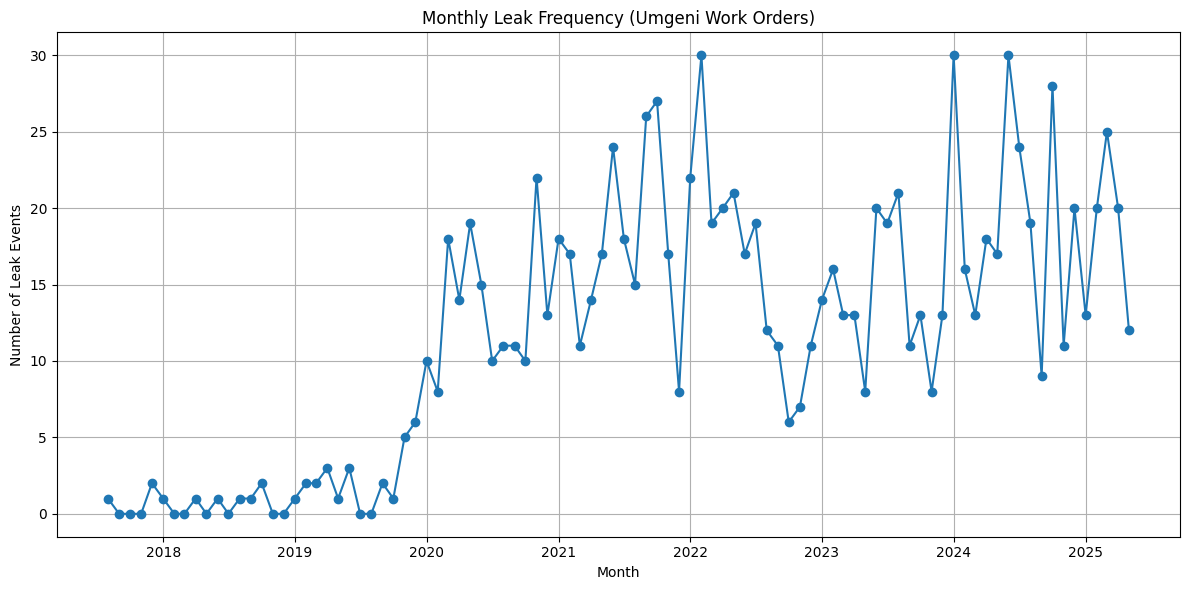

In [7]:
# 1) Filter valid rows
mask = (rep.get("target_leak", 0) == 1) & rep["event_date"].notna()
if not mask.any():
    print("No leak rows with valid event_date.")
else:
    # 2) Aggregate by month via PeriodIndex (fast)
    monthly_leaks = (
        rep.loc[mask, "event_date"]
          .dt.to_period("M")
          .value_counts()
          .rename_axis("event_period")
          .reset_index(name="leak_count")
          .sort_values("event_period")
    )

    # 3) Ensure a complete monthly index (fill missing months with 0)
    start = monthly_leaks["event_period"].min()
    end   = monthly_leaks["event_period"].max()
    full_idx = pd.period_range(start=start, end=end, freq="M")
    monthly_leaks = (
        monthly_leaks.set_index("event_period")
                     .reindex(full_idx, fill_value=0)
                     .rename_axis("event_period")
                     .reset_index()
    )
    # Convert Period → Timestamp for plotting on a datetime axis
    monthly_leaks["event_period"] = monthly_leaks["event_period"].dt.to_timestamp()

    # Optional: add a rolling average (e.g., 3-month)
    # monthly_leaks["leak_roll3"] = monthly_leaks["leak_count"].rolling(3, min_periods=1).mean()

    # 4) Plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_leaks["event_period"], monthly_leaks["leak_count"], marker="o")
    # If you enabled rolling mean:
    # plt.plot(monthly_leaks["event_period"], monthly_leaks["leak_roll3"], linestyle="--")

    plt.title("Monthly Leak Frequency (Umgeni Work Orders)")
    plt.xlabel("Month")
    plt.ylabel("Number of Leak Events")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Yearly leak distribution (complete year range + labels)
- Count leaks by **calendar year** from `event_date`.
- Reindex to a continuous year range (min → max) so missing years show as 0.
- Plot a labeled bar chart for quick comparison.


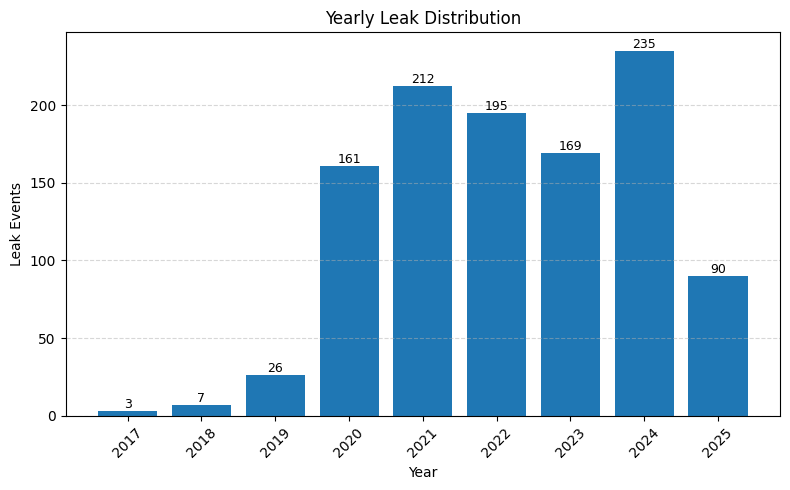

In [8]:
# Filter valid leak rows with a parsed date
mask = (rep.get("target_leak", 0) == 1) & rep["event_date"].notna()

if not mask.any():
    print("No leak rows with valid event_date — yearly chart skipped.")
else:
    # Count by year directly from event_date
    yr_counts = rep.loc[mask, "event_date"].dt.year.value_counts().sort_index()

    # Ensure a complete year range (fill missing with 0)
    yr_min, yr_max = int(yr_counts.index.min()), int(yr_counts.index.max())
    full_years = pd.Index(range(yr_min, yr_max + 1), name="Year")
    yearly_leaks = yr_counts.reindex(full_years, fill_value=0)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(yearly_leaks.index.astype(int), yearly_leaks.values)
    plt.title("Yearly Leak Distribution")
    plt.xlabel("Year")
    plt.ylabel("Leak Events")
    plt.xticks(yearly_leaks.index.astype(int), rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Annotate bars with counts
    for x, v in zip(yearly_leaks.index.astype(int), yearly_leaks.values):
        plt.text(x, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


## Monthly work orders: Leak vs Non-Leak (stacked bars, complete timeline)
We crosstab counts by calendar month and leak flag, reindex to a full monthly range,
fill missing months with 0, and plot a stacked bar chart. Tick labels are thinned
to keep the axis readable on long timelines.


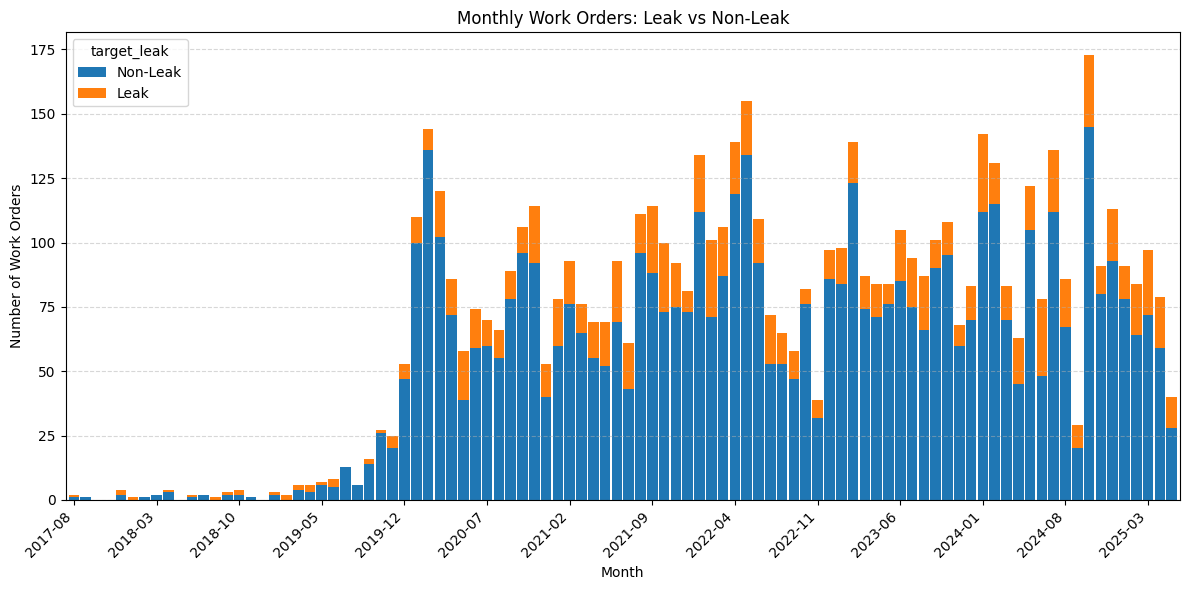

In [9]:
# Filter rows with a valid date
mask = rep["event_date"].notna()
if not mask.any():
    print("No rows with a valid event_date — chart skipped.")
else:
    # Build monthly period index
    months = rep.loc[mask, "event_date"].dt.to_period("M")

    # Crosstab: rows = month, cols = target_leak (0/1). Missing values -> 0.
    monthly_pivot = pd.crosstab(months, rep.loc[mask, "target_leak"]).sort_index()

    # Ensure both columns (0 and 1) exist; add if missing
    for col in [0, 1]:
        if col not in monthly_pivot.columns:
            monthly_pivot[col] = 0

    # Rename to friendly labels and reorder columns [Non-Leak, Leak]
    monthly_pivot = monthly_pivot[[0, 1]].rename(columns={0: "Non-Leak", 1: "Leak"})

    # Reindex to complete monthly range (min→max), fill with 0
    full_idx = pd.period_range(monthly_pivot.index.min(), monthly_pivot.index.max(), freq="M")
    monthly_pivot = monthly_pivot.reindex(full_idx, fill_value=0)

    # Convert PeriodIndex -> Timestamp for plotting
    idx_ts = monthly_pivot.index.to_timestamp()

    # Plot: stacked bar
    ax = monthly_pivot.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        width=0.9,
    )
    ax.set_title("Monthly Work Orders: Leak vs Non-Leak")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Work Orders")

    # Make x-axis readable: show ~12 evenly spaced tick labels
    n = len(idx_ts)
    if n > 0:
        step = max(1, n // 12)
        ax.set_xticks(range(0, n, step))
        ax.set_xticklabels([idx_ts[i].strftime("%Y-%m") for i in range(0, n, step)], rotation=45, ha="right")

    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


## Build asset/pipeline join keys (vectorized, with smart fallbacks)
- **Asset key (from work orders):** pick the first non-null of  
  `["Functional Loc.", "Description", "Location_Description"]` (in that order), clean, then normalize.
- **Pipeline key (from attributes):** prefer `"PIPELINE NAME"`, else `"FROM"+"TO"`, else `"SUB SYSTEM"`, then normalize.
- Includes a tiny QA printout (nulls and a few duplicate keys) to spot join issues early.


In [10]:
# -------------------------------
# Asset key from replacement orders (vectorized)
# -------------------------------
asset_candidates = ["Functional Loc.", "Description", "Location_Description"]
avail = [c for c in asset_candidates if c in rep.columns]

if avail:
    # Clean each candidate column, then take the first non-null per row
    tmp = rep[avail].apply(clean_text)          # uses your Series-aware cleaner
    asset_key_raw = tmp.bfill(axis=1).iloc[:, 0]
else:
    # If none of the candidates exist, create an all-null Series
    asset_key_raw = pd.Series(pd.NA, index=rep.index, dtype="string")

rep["asset_key_raw"] = asset_key_raw
# Normalize to a joinable key (lowercase, alnum+space, collapsed)
rep["asset_key"] = norm_key(rep["asset_key_raw"])

# -------------------------------
# Pipeline key from attributes (PIPELINE NAME → FROM+TO → SUB SYSTEM)
# -------------------------------
idx = mat.index
pipe_key_raw = pd.Series(pd.NA, index=idx, dtype="string")

# 1) Prefer PIPELINE NAME
if "PIPELINE NAME" in mat.columns:
    pipe_key_raw = clean_text(mat["PIPELINE NAME"])

# 2) Fallback: FROM + TO
if ("FROM" in mat.columns) or ("TO" in mat.columns):
    from_series = mat.get("FROM", pd.Series("", index=idx)).astype("string").fillna("")
    to_series   = mat.get("TO",   pd.Series("", index=idx)).astype("string").fillna("")
    ft = (from_series + " " + to_series).str.strip()
    ft = clean_text(ft)
    pipe_key_raw = pipe_key_raw.fillna(ft)

# 3) Last fallback: SUB SYSTEM
if "SUB SYSTEM" in mat.columns:
    sub = clean_text(mat["SUB SYSTEM"])
    pipe_key_raw = pipe_key_raw.fillna(sub)

mat["pipe_key_raw"] = pipe_key_raw
mat["pipe_key"] = norm_key(mat["pipe_key_raw"])

# -------------------------------
# Quick QA: nulls & potential duplicates
# -------------------------------
def _qa_keys(name, s: pd.Series):
    nulls = int(s.isna().sum())
    uniq = int(s.nunique(dropna=True))
    total = len(s)
    print(f"{name}: total={total}, unique(non-null)={uniq}, nulls={nulls}")
    # Show a few duplicate keys if any
    dups = s[s.notna()].value_counts()
    dups = dups[dups > 1]
    if not dups.empty:
        print(f"  {len(dups)} duplicate keys (top 5):")
        for k, v in dups.head(5).items():
            print(f"   • {k!r}: {v}")

_qa_keys("rep.asset_key", rep["asset_key"])
_qa_keys("mat.pipe_key",  mat["pipe_key"])


rep.asset_key: total=6260, unique(non-null)=659, nulls=0
  443 duplicate keys (top 5):
   • 'uw ii e mkon sup ops am0 build': 400
   • 'uw ii w midm bds urd lpa pipel': 221
   • 'uw ii e dvha bds war ms1 pipel': 159
   • 'uw ii w midm bds 056 56e pipel': 141
   • 'uw ii w midm bds 056 56e res01': 132
mat.pipe_key: total=88, unique(non-null)=35, nulls=14
  17 duplicate keys (top 5):
   • 'wartburg pipeline': 9
   • '251 pipeline': 6
   • '61 pipeline': 5
   • 'pipeline name': 5
   • '261 pipeline': 4


## Map asset keys to pipelines (stable dictionary)
We map each distinct `asset_key` to a `pipe_key` using:
1) Numeric ID match (e.g., "251" ↔ "251 pipeline"),
2) Token overlap against pipeline names with a small threshold,
3) Extra bonus if tokens appear in `FROM`/`TO`.

We then join this mapping back to all rows and print a match report.


In [11]:
# -----------------------------
# 0) Config: stopwords & thresholds
# -----------------------------
STOP = {
    # common boilerplate from Functional Loc / descriptions
    "uw","ii","e","w","wtw","rwt","rws","ops","adm","build","am0","am00",
    "bds","res","res01","res02","ch001","ch002","ch051","ms1","cnr","eup","eub",
    "mup","mids","midm","dvha","dvw","ixw","ixop","darv","www","sgp","war","urd","lpa",
    "pipel","pipe","valve","est","eso","eup","eur","ws","wsh",
}
NUM_RE   = re.compile(r"\b(\d{2,4})\b")       # catch 2–4 digit IDs (e.g., 56, 251, 261)
ALNUM_RE = re.compile(r"[a-z0-9]{3,}")        # tokens >=3 chars

JACCARD_THR = 0.40  # slightly relaxed to improve recall

# -----------------------------
# 1) Prep: uniques and available columns
# -----------------------------
asset_uni = rep["asset_key"].dropna().unique().tolist()

# ensure these columns exist before we use them
mat_cols = [c for c in ["pipe_key", "PIPELINE NAME", "FROM", "TO",
                        "SYSTEM","SUB SYSTEM","Material",
                        "TOTAL LENGTH (KM)","Nominal Diameter",
                        "CAPACITY MLD","PIPELINE AGE"]
            if c in mat.columns]

pipe_df = mat[mat_cols].dropna(subset=["pipe_key"]).drop_duplicates("pipe_key").copy()
pipe_keys = pipe_df["pipe_key"].tolist()

# -----------------------------
# 2) Token helpers (denoise)
# -----------------------------
def _tokset(s):
    if pd.isna(s): 
        return set()
    toks = set(t for t in ALNUM_RE.findall(str(s).lower()) if t not in STOP)
    return toks

# precompute pipe tokens and optional FROM/TO bonuses
pipe_tok = {pk: _tokset(pk) for pk in pipe_keys}
pipe_fromtok = {}
pipe_totok   = {}
if "FROM" in pipe_df.columns:
    for pk in pipe_keys:
        val = pipe_df.loc[pipe_df["pipe_key"] == pk, "FROM"]
        pipe_fromtok[pk] = _tokset(val.iloc[0]) if not val.empty else set()
else:
    pipe_fromtok = {pk: set() for pk in pipe_keys}
if "TO" in pipe_df.columns:
    for pk in pipe_keys:
        val = pipe_df.loc[pipe_df["pipe_key"] == pk, "TO"]
        pipe_totok[pk] = _tokset(val.iloc[0]) if not val.empty else set()
else:
    pipe_totok = {pk: set() for pk in pipe_keys}

# numeric tokens
rep_assetnum_map = {ak: (NUM_RE.search(ak).group(1) if NUM_RE.search(ak) else None)
                    for ak in asset_uni}
pipe_num_map = {pk: (NUM_RE.search(pk).group(1) if NUM_RE.search(pk) else None)
                for pk in pipe_keys}

from collections import defaultdict
num_to_pipes = defaultdict(list)
for pk, num in pipe_num_map.items():
    if num:
        num_to_pipes[num].append(pk)

# -----------------------------
# 3) Scoring function
# -----------------------------
def _score_match(asset: str, pk: str) -> float:
    A = _tokset(asset)
    B = pipe_tok.get(pk, set())
    if not A or not B:
        base = 0.0
    else:
        inter = len(A & B)
        base = 0.0 if inter == 0 else inter / len(A | B)
    # small context bonus for FROM/TO overlap
    bonus = 0.0
    if A & pipe_fromtok.get(pk, set()):
        bonus += 0.05
    if A & pipe_totok.get(pk, set()):
        bonus += 0.05
    return base + bonus

# -----------------------------
# 4) Build mapping: asset_key -> pipe_key
# -----------------------------
asset_to_pipe = {}

# Pass 1: numeric token match; if multiple candidates, pick best score
for ak, num in rep_assetnum_map.items():
    if num and num in num_to_pipes:
        cands = num_to_pipes[num]
        if len(cands) == 1:
            asset_to_pipe[ak] = cands[0]
        else:
            best = max(cands, key=lambda pk: _score_match(ak, pk))
            asset_to_pipe[ak] = best

# Pass 2: token-overlap fallback
for ak in asset_uni:
    if ak in asset_to_pipe:
        continue
    best_pk, best_s = None, 0.0
    for pk in pipe_keys:
        s = _score_match(ak, pk)
        if s > best_s:
            best_s, best_pk = s, pk
    asset_to_pipe[ak] = best_pk if (best_pk is not None and best_s >= JACCARD_THR) else None

# -----------------------------
# 5) Attach to rep and merge attributes
# -----------------------------
rep["pipe_key_match"] = rep["asset_key"].map(asset_to_pipe)

cols_from_mat = [c for c in ["pipe_key","SYSTEM","SUB SYSTEM","PIPELINE NAME","Material",
                             "TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD",
                             "PIPELINE AGE","FROM","TO"]
                 if c in mat.columns]

rep = rep.merge(
    mat[cols_from_mat].drop_duplicates("pipe_key"),
    left_on="pipe_key_match",
    right_on="pipe_key",
    how="left",
)

# -----------------------------
# 6) Reports (safe columns)
# -----------------------------
hit_rate = rep["pipe_key_match"].notna().mean() * 100
print(f"Mapped rows: {hit_rate:.1f}%")

# Coverage among top asset_keys
top_assets = rep["asset_key"].value_counts().head(10).index.tolist()
cov = (rep.assign(hit=rep["pipe_key_match"].notna())
         .groupby("asset_key")["hit"].mean()
         .reindex(top_assets))
print("Coverage among top asset_keys (fraction mapped):")
print(cov.fillna(0).round(3).to_dict())

# Safe display (only show columns that exist)
show_cols = ["asset_key","pipe_key_match","PIPELINE NAME","FROM","TO"]
show_cols = [c for c in show_cols if c in rep.columns]
print("\nSample mapped:")
display(rep.loc[rep["pipe_key_match"].notna(), show_cols].head(8))

print("Sample UNmapped:")
display(rep.loc[rep["pipe_key_match"].isna(), ["asset_key"]].head(8))


Mapped rows: 3.8%
Coverage among top asset_keys (fraction mapped):
{'uw ii e mkon sup ops am0 build': 0.0, 'uw ii w midm bds urd lpa pipel': 0.0, 'uw ii e dvha bds war ms1 pipel': 0.0, 'uw ii w midm bds 056 56e pipel': 0.0, 'uw ii w midm bds 056 56e res01': 0.0, 'uw ii w midm bds est eso pipel': 0.0, 'uw ii w midm bds 056 56e valve': 0.0, 'uw ii w midm bds 061 61g pipel': 0.0, 'uw ii e dvha bds 060 cnr build': 0.0, 'uw ii e dvha wtw dvw adm build': 0.0}

Sample mapped:


,asset_key,pipe_key_match,PIPELINE NAME,FROM,TO
6,uw ii w midm bds 251 251 pipel,251 pipeline,‘251 Pipeline,Midmar Raw Water Pump Station,Midmar WTP
7,uw ii w midm bds 261 261 ch001,261 pipeline,261 Pipeline,World’s View Reservoir,H.D. Hill
10,uw ii w midm bds 251 pha pipel,251 pipeline,‘251 Pipeline,Midmar Raw Water Pump Station,Midmar WTP
21,uw ii w midm bds 261 261 ch036,261 pipeline,261 Pipeline,World’s View Reservoir,H.D. Hill
35,uw ii w midm bds 251 pha pipel,251 pipeline,‘251 Pipeline,Midmar Raw Water Pump Station,Midmar WTP
44,uw ii w midm bds 357 357 ch001,357 pipeline,’357 Pipeline,Umlaas Road,Point M
47,uw ii w midm bds 257 257 ch001,257 pipeline,’257 Pipeline,Umlaas Road (Phase 3),Cato Ridge Bifurcation
55,uw ii w midm bds 261 261 ch001,261 pipeline,261 Pipeline,World’s View Reservoir,H.D. Hill


Sample UNmapped:


,asset_key
0,uw ii e dvha bds 053 53a pipel
1,uw ii e mkon sup ops am0 build
2,uw ii w muts rwt mup bgo build
3,uw ii e darv www dar adm build
4,uw ii e dvha bds 053 53a ch051
5,uw ii e dvha bds war ms1 pipel
8,uw ii w midm bds eup eub ch002
9,uw ii e ixop wtw ixw adm build


## Exact key match (asset_key ↔ pipe_key): hit rate & diagnostics
We check exact matches between normalized keys, report:
- overall match rate (rows),
- unique `asset_key` coverage,
- top unmapped `asset_key`s (by frequency),
and show a small sample of matches.


In [12]:
# ===========================================================
# Better linkage: (1) flexible numeric match, (2) name alias match
# ===========================================================

# 0) Prep
asset_uni = rep["asset_key"].dropna().unique().tolist()
pipe_df = mat.dropna(subset=["pipe_key"]).drop_duplicates("pipe_key").copy()

# 1) --- Flexible numeric mapping ---
# Extract *all* 2–4 digit numbers from asset_key (e.g., 56, 060, 061, 251, 261)
def _nums_in_text(s: str) -> set[str]:
    if pd.isna(s): return set()
    # grab 2–4 digit chunks and also strip trailing letters like '61g' -> '61'
    raw = re.findall(r"\b(\d{2,4})[a-z]?\b", str(s).lower())
    return set(raw)

# Build set of pipeline numbers from pipe_key (e.g., '61 pipeline' -> '61')
pipe_keys = pipe_df["pipe_key"].tolist()
pipe_num_map = {}
for pk in pipe_keys:
    nums = re.findall(r"\b(\d{2,4})\b", pk.lower())
    pipe_num_map[pk] = set(nums)

# Reverse map: number -> pipe_keys containing it
from collections import defaultdict
num_to_pipes = defaultdict(set)
for pk, nums in pipe_num_map.items():
    for n in nums:
        num_to_pipes[n].add(pk)

# 2) --- Name alias mapping ---
# Build alias tokens from PIPELINE NAME / pipe_key:
# take meaningful tokens (>=4 chars) excluding generic words & 'pipeline'
GENERIC = {"pipeline", "new", "main", "line"}
def _alias_tokens(s: str) -> set[str]:
    if pd.isna(s): return set()
    toks = set(re.findall(r"[a-z0-9]{4,}", str(s).lower()))
    return {t for t in toks if t not in GENERIC and not t.isdigit()}

# Gather alias -> set(pipe_keys)
alias_to_pipes = defaultdict(set)
for _, row in pipe_df.iterrows():
    pk = row["pipe_key"]
    # prefer PIPELINE NAME when present; else use pipe_key
    base = row["PIPELINE NAME"] if "PIPELINE NAME" in row and pd.notna(row["PIPELINE NAME"]) else pk
    for tok in (_alias_tokens(base) | _alias_tokens(pk)):
        alias_to_pipes[tok].add(pk)

# Keep only unambiguous aliases (map to exactly one pipe)
alias_to_pipe = {a: list(pks)[0] for a, pks in alias_to_pipes.items() if len(pks) == 1}

# 3) --- Build text to search per work order (use RAW fields, not only normalized) ---
def _row_text(irow) -> str:
    parts = []
    for c in ["asset_key_raw", "Description", "Location_Description", "Problem_Description"]:
        if c in rep.columns:
            parts.append(str(irow.get(c, "")))
    return " ".join(parts).lower()

# 4) --- Decide mapping per unique asset_key ---
asset_to_pipe = {}

for ak in asset_uni:
    # Grab a representative row for raw text (first occurrence)
    sample_row = rep.loc[rep["asset_key"] == ak].iloc[0].to_dict()

    # First: numeric candidates
    nums = _nums_in_text(ak)
    num_candidates = set()
    for n in nums:
        num_candidates |= num_to_pipes.get(n, set())

    # Second: alias candidates (search in RAW text, more likely to contain place names)
    text_blob = _row_text(sample_row)
    alias_hits = {alias for alias in alias_to_pipe.keys() if alias in text_blob}
    alias_candidates = {alias_to_pipe[a] for a in alias_hits}

    # Combine candidates; if none, leave unmatched
    candidates = list(num_candidates | alias_candidates)
    if not candidates:
        asset_to_pipe[ak] = None
        continue

    # If exactly one candidate, take it
    if len(candidates) == 1:
        asset_to_pipe[ak] = candidates[0]
        continue

    # If multiple: score by simple token overlap (Jaccard) using pipe name tokens
    def _tokset(s):
        return set(re.findall(r"[a-z0-9]{3,}", s.lower()))
    aset = _tokset(ak + " " + text_blob)
    best_pk, best_s = None, 0.0
    for pk in candidates:
        pset = _tokset(pk)
        if not aset or not pset:
            s = 0.0
        else:
            inter = len(aset & pset)
            s = 0.0 if inter == 0 else inter / len(aset | pset)
        if s > best_s:
            best_s, best_pk = s, pk
    # small threshold; candidates already constrained
    asset_to_pipe[ak] = best_pk if best_pk is not None and best_s >= 0.15 else None

# 5) Attach and merge attributes
rep["pipe_key_match"] = rep["asset_key"].map(asset_to_pipe)

cols_from_mat = [c for c in [
    "pipe_key","SYSTEM","SUB SYSTEM","PIPELINE NAME","Material",
    "TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD","PIPELINE AGE","FROM","TO"
] if c in mat.columns]

rep = rep.merge(
    mat[cols_from_mat].drop_duplicates("pipe_key"),
    left_on="pipe_key_match",
    right_on="pipe_key",
    how="left",
)

# 6) Report
hit_rate = rep["pipe_key_match"].notna().mean() * 100
print(f"Mapped rows: {hit_rate:.1f}%")

top_assets = rep["asset_key"].value_counts().head(10).index.tolist()
cov = (rep.assign(hit=rep["pipe_key_match"].notna())
         .groupby("asset_key")["hit"].mean()
         .reindex(top_assets))
print("Coverage among top asset_keys (fraction mapped):")
print(cov.fillna(0).round(3).to_dict())

show_cols = [c for c in ["asset_key","pipe_key_match","PIPELINE NAME","SYSTEM","SUB SYSTEM","FROM","TO"] if c in rep.columns]
print("\nSample mapped:")
display(rep.loc[rep["pipe_key_match"].notna(), show_cols].head(10))

print("Sample UNmapped:")
display(rep.loc[rep["pipe_key_match"].isna(), ["asset_key"]].head(10))


Mapped rows: 43.5%
Coverage among top asset_keys (fraction mapped):
{'uw ii e mkon sup ops am0 build': 0.0, 'uw ii w midm bds urd lpa pipel': 1.0, 'uw ii e dvha bds war ms1 pipel': 0.0, 'uw ii w midm bds 056 56e pipel': 1.0, 'uw ii w midm bds 056 56e res01': 1.0, 'uw ii w midm bds est eso pipel': 1.0, 'uw ii w midm bds 056 56e valve': 1.0, 'uw ii w midm bds 061 61g pipel': 1.0, 'uw ii e dvha bds 060 cnr build': 0.0, 'uw ii e dvha wtw dvw adm build': 0.0}

Sample mapped:


,asset_key,pipe_key_match
0,uw ii e dvha bds 053 53a pipel,53 pipeline
4,uw ii e dvha bds 053 53a ch051,53 pipeline
6,uw ii w midm bds 251 251 pipel,251 pipeline
8,uw ii w midm bds eup eub ch002,eston umbumbulu pipeline
10,uw ii w midm bds 251 pha pipel,251 pipeline
11,uw ii w midm bds 061 61f pipel,61 pipeline
12,uw ii w midm bds est eso pipel,eston umbumbulu pipeline
15,uw ii w midm bds 061 61f pipel,61 pipeline
16,uw ii e ixop rwt ixw abs pipel,ixopo raw water rising main
17,uw ii w midm bds man pha ch003,manyavu pipeline


Sample UNmapped:


,asset_key
1,uw ii e mkon sup ops am0 build
2,uw ii w muts rwt mup bgo build
3,uw ii e darv www dar adm build
5,uw ii e dvha bds war ms1 pipel
7,uw ii w midm bds 261 261 ch001
9,uw ii e ixop wtw ixw adm build
13,uw ii w muts rwt mup sgp build
14,uw ii w midm bds vul vua res01
18,uw ii e dvha bds war wbr build
19,uw ii e dvha bds 051 051 ch001


In [13]:
# ===========================================================
# Post-boost: leading-zero numbers + 4-letter name aliases
# ===========================================================

# 1) Normalize numbers in both sides (060 -> 60) and re-try numeric mapping
def _norm_nums(s: str) -> set[str]:
    if pd.isna(s): return set()
    nums = re.findall(r"\b(\d{2,4})\b", str(s))
    normed = set()
    for n in nums:
        try:
            normed.add(str(int(n)))   # strips leading zeros
        except Exception:
            pass
    return normed

pipe_df2 = mat.dropna(subset=["pipe_key"]).drop_duplicates("pipe_key").copy()
pipe_keys2 = pipe_df2["pipe_key"].tolist()

num_to_pipes_norm = {}
from collections import defaultdict
tmp_map = defaultdict(set)
for pk in pipe_keys2:
    for n in _norm_nums(pk):
        tmp_map[n].add(pk)
num_to_pipes_norm = dict(tmp_map)

# try to fill only the still-unmatched rows by normalized numbers
mask_un = rep["pipe_key_match"].isna()
if mask_un.any():
    # representative asset_key → normalized number set
    ak_nums = rep.loc[mask_un, "asset_key"].dropna().unique().tolist()
    ak_to_normnums = {ak: _norm_nums(ak) for ak in ak_nums}

    new_map = {}
    for ak, nn in ak_to_normnums.items():
        cands = set()
        for n in nn:
            cands |= num_to_pipes_norm.get(n, set())
        new_map[ak] = list(cands)[0] if len(cands) == 1 else (None if not cands else None)

    # apply: only single-candidate cases to avoid mistakes
    fill = rep["asset_key"].map(new_map)
    rep.loc[mask_un & fill.notna(), "pipe_key_match"] = fill

# 2) 4-letter alias prefixes from true pipeline names (unambiguous only)
def _alias_tokens(s: str) -> set[str]:
    if pd.isna(s): return set()
    toks = set(re.findall(r"[a-z0-9]{4,}", str(s).lower()))
    return {t for t in toks if t != "pipeline" and not t.isdigit()}

pipe_df_names = mat.dropna(subset=["pipe_key"]).drop_duplicates("pipe_key").copy()
name_tokens = {}
for _, row in pipe_df_names.iterrows():
    pk = row["pipe_key"]
    base = row["PIPELINE NAME"] if "PIPELINE NAME" in row and pd.notna(row["PIPELINE NAME"]) else pk
    name_tokens[pk] = (_alias_tokens(base) | _alias_tokens(pk))

# build prefix alias → pipe_key, keep only unambiguous prefixes
from collections import defaultdict
pref_to_pipes = defaultdict(set)
for pk, toks in name_tokens.items():
    for t in toks:
        pref = t[:4]
        pref_to_pipes[pref].add(pk)

pref_alias = {p: list(v)[0] for p, v in pref_to_pipes.items() if len(v) == 1}

# 3) search those prefixes in RAW text fields for remaining unmatched rows
def _row_blob(row) -> str:
    parts = []
    for c in ["asset_key_raw","Description","Location_Description","Problem_Description"]:
        if c in row and pd.notna(row[c]):
            parts.append(str(row[c]))
    return " ".join(parts).lower()

mask_un = rep["pipe_key_match"].isna()
if mask_un.any():
    # we’ll take the first matching prefix (they are unambiguous by construction)
    def _prefix_hit(row):
        blob = _row_blob(row)
        hits = [pref for pref in pref_alias.keys() if pref in blob]
        return pref_alias[hits[0]] if hits else None

    cand = rep.loc[mask_un].apply(_prefix_hit, axis=1)
    rep.loc[mask_un & cand.notna(), "pipe_key_match"] = cand

# 4) (optional) tiny tie-break scoring among a few candidates (if you want)
# Skipped here to keep it simple.

# 5) Report delta
hit_rate = rep["pipe_key_match"].notna().mean() * 100
print(f"Mapped rows after boost: {hit_rate:.1f}%")

show_cols = [c for c in ["asset_key","pipe_key_match","PIPELINE NAME","SYSTEM","SUB SYSTEM","FROM","TO"] if c in rep.columns]
print("\nSample newly mapped after boost:")
display(rep.loc[rep["pipe_key_match"].notna(), show_cols].tail(10))


Mapped rows after boost: 59.7%

Sample newly mapped after boost:


,asset_key,pipe_key_match
6244,uw ii w lynf www lyn adm build,lion park pipeline
6245,uw ii w midm bds 061 61f pipel,61 pipeline
6246,uw ii w rich www ric ris build,richmond pipeline
6247,uw ii e camp www cas inl build,table mountain pipeline
6248,uw ii w lynf www lyn adm build,lion park pipeline
6249,uw ii e dvha bds 069 69e pipel,wartburg pipeline 69 pipeline
6250,uw ii e dvha bds 060 cnr build,60 pipeline
6251,uw ii w midm bds 063 63a pipel,richmond pipeline
6253,uw ii w midm bds man pha pipel,manyavu pipeline
6257,uw ii e ixop rwt ixw abs pipel,ixopo raw water rising main


## Match provenance, manual alias boost, and persistence
- Tag each mapped row with the **reason** it matched (num / alias / prefix / jaccard).
- Add a small **manual alias** table (place names) to bump recall on stubborn cases.
- Persist a stable `asset_key → pipe_key` mapping for reuse & audit.
- Provide a quick **QA sample** to eyeball precision.


In [14]:
# -------------------------------
# Asset key from replacement orders (vectorized)
# -------------------------------
asset_candidates = ["Functional Loc.", "Description", "Location_Description"]
avail = [c for c in asset_candidates if c in rep.columns]

if avail:
    # Clean each candidate column, then take the first non-null per row
    tmp = rep[avail].apply(clean_text)          # uses your Series-aware cleaner
    asset_key_raw = tmp.bfill(axis=1).iloc[:, 0]
else:
    # If none of the candidates exist, create an all-null Series
    asset_key_raw = pd.Series(pd.NA, index=rep.index, dtype="string")

rep["asset_key_raw"] = asset_key_raw
# Normalize to a joinable key (lowercase, alnum+space, collapsed)
rep["asset_key"] = norm_key(rep["asset_key_raw"])

# -------------------------------
# Pipeline key from attributes (PIPELINE NAME → FROM+TO → SUB SYSTEM)
# -------------------------------
idx = mat.index
pipe_key_raw = pd.Series(pd.NA, index=idx, dtype="string")

# 1) Prefer PIPELINE NAME
if "PIPELINE NAME" in mat.columns:
    pipe_key_raw = clean_text(mat["PIPELINE NAME"])

# 2) Fallback: FROM + TO
if ("FROM" in mat.columns) or ("TO" in mat.columns):
    from_series = mat.get("FROM", pd.Series("", index=idx)).astype("string").fillna("")
    to_series   = mat.get("TO",   pd.Series("", index=idx)).astype("string").fillna("")
    ft = (from_series + " " + to_series).str.strip()
    ft = clean_text(ft)
    pipe_key_raw = pipe_key_raw.fillna(ft)

# 3) Last fallback: SUB SYSTEM
if "SUB SYSTEM" in mat.columns:
    sub = clean_text(mat["SUB SYSTEM"])
    pipe_key_raw = pipe_key_raw.fillna(sub)

mat["pipe_key_raw"] = pipe_key_raw
mat["pipe_key"] = norm_key(mat["pipe_key_raw"])

# -------------------------------
# Quick QA: nulls & potential duplicates
# -------------------------------
def _qa_keys(name, s: pd.Series):
    nulls = int(s.isna().sum())
    uniq = int(s.nunique(dropna=True))
    total = len(s)
    print(f"{name}: total={total}, unique(non-null)={uniq}, nulls={nulls}")
    # Show a few duplicate keys if any
    dups = s[s.notna()].value_counts()
    dups = dups[dups > 1]
    if not dups.empty:
        print(f"  {len(dups)} duplicate keys (top 5):")
        for k, v in dups.head(5).items():
            print(f"   • {k!r}: {v}")

_qa_keys("rep.asset_key", rep["asset_key"])
_qa_keys("mat.pipe_key",  mat["pipe_key"])


rep.asset_key: total=6260, unique(non-null)=659, nulls=0
  443 duplicate keys (top 5):
   • 'uw ii e mkon sup ops am0 build': 400
   • 'uw ii w midm bds urd lpa pipel': 221
   • 'uw ii e dvha bds war ms1 pipel': 159
   • 'uw ii w midm bds 056 56e pipel': 141
   • 'uw ii w midm bds 056 56e res01': 132
mat.pipe_key: total=88, unique(non-null)=35, nulls=14
  17 duplicate keys (top 5):
   • 'wartburg pipeline': 9
   • '251 pipeline': 6
   • '61 pipeline': 5
   • 'pipeline name': 5
   • '261 pipeline': 4


In [15]:
# ---------- 1) Provenance tags for current matches (explainability) ----------
def _norm_nums(s):
    if pd.isna(s): return set()
    nums = re.findall(r"\b(\d{2,4})\b", str(s))
    out = set()
    for n in nums:
        try: out.add(str(int(n)))  # strip leading zeros
        except Exception: pass
    return out

def _row_blob_from_rep_row(row):
    parts = []
    for c in ["asset_key_raw","Description","Location_Description","Problem_Description"]:
        if c in rep.columns and c in row and pd.notna(row[c]):
            parts.append(str(row[c]))
    return " ".join(parts).lower()

# these may exist from the previous mapping step; guard if not
alias_to_pipe = globals().get("alias_to_pipe", {})
pref_alias    = globals().get("pref_alias", {})

def _match_reason(row):
    reasons = []
    ak = row.get("asset_key")
    pk = row.get("pipe_key_match")
    if pd.isna(pk) or pd.isna(ak):
        return None
    # numeric overlap?
    if _norm_nums(ak) & _norm_nums(pk):
        reasons.append("num")
    # alias hit?
    blob = _row_blob_from_rep_row(row)
    if alias_to_pipe:
        for alias, target in alias_to_pipe.items():
            if target == pk and alias in blob:
                reasons.append(f"alias:{alias}")
                break
    # prefix hit?
    if pref_alias:
        for pref, target in pref_alias.items():
            if target == pk and pref in blob:
                reasons.append(f"prefix:{pref}")
                break
    if not reasons:
        reasons.append("jaccard")
    return ",".join(reasons)

if "pipe_key_match" in rep.columns:
    rep["match_reason"] = rep.apply(_match_reason, axis=1)
    print("Provenance tagged (column: match_reason).")

# ---------- 2) Manual alias boost (safe & tiny) ----------
# Only try to map rows still unmatched
MANUAL_ALIASES = {
    # pipeline_key : list of distinctive substrings to search in RAW text
    "wartburg pipeline":      ["wartburg"],
    "howick pipeline":        ["howick"],
    "richmond pipeline":      ["richmond","richm"],
    "sweetwaters pipeline":   ["sweetwaters","sweetw","sweets"],
    "bruyns hill pipeline":   ["bruyns hill","bruyns","bruyn"],
    "manyavu pipeline":       ["manyavu","manyav","many"],
    "251 pipeline":           [" 251 "," 251-","-251"," 251,"],   # delimiters reduce false positives
    "261 pipeline":           [" 261 "," 261-","-261"," 261,"],
    "61 pipeline":            [" 61 "," 61-","-61"," 61,"],
    "60 pipeline":            [" 60 "," 60-","-60"," 60,"],
}

def _blob_contains_any(blob, needles):
    b = " " + blob + " "  # pad to make delimiter checks easier
    return any(n.lower() in b for n in needles)

mask_un = rep["pipe_key_match"].isna() if "pipe_key_match" in rep.columns else pd.Series(False, index=rep.index)
if mask_un.any():
    def _manual_pick(row):
        blob = _row_blob_from_rep_row(row)
        hits = [pk for pk, needles in MANUAL_ALIASES.items() if _blob_contains_any(blob, needles)]
        # only commit if unambiguous
        return hits[0] if len(hits) == 1 else None

    cand = rep.loc[mask_un].apply(_manual_pick, axis=1)
    filled = cand.notna().sum()
    rep.loc[mask_un & cand.notna(), "pipe_key_match"] = cand
    if filled:
        print(f"Manual alias booster mapped {filled} more rows.")

# Re-merge attributes for new matches (idempotent and safe)
if "pipe_key_match" in rep.columns and "pipe_key" in mat.columns:
    cols_from_mat = [c for c in [
        "pipe_key","SYSTEM","SUB SYSTEM","PIPELINE NAME","Material",
        "TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD","PIPELINE AGE","FROM","TO"
    ] if c in mat.columns]
    rep = rep.drop(columns=[c for c in ["pipe_key","SYSTEM","SUB SYSTEM","PIPELINE NAME","Material",
                                        "TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD",
                                        "PIPELINE AGE","FROM","TO"] if c in rep.columns], errors="ignore")
    rep = rep.merge(
        mat[cols_from_mat].drop_duplicates("pipe_key"),
        left_on="pipe_key_match",
        right_on="pipe_key",
        how="left",
    )

# ---------- 3) Persist mapping & quick QA ----------
if "pipe_key_match" in rep.columns:
    hit_rate = rep["pipe_key_match"].notna().mean() * 100
    print(f"Mapped rows (now): {hit_rate:.1f}%")

    # Save stable mapping dictionary for reuse
    mapping = (rep[["asset_key","pipe_key_match"]]
               .dropna()
               .drop_duplicates()
               .rename(columns={"pipe_key_match": "pipe_key"}))
    mapping.to_csv("asset_to_pipe_map.csv", index=False)
    print("Saved mapping to asset_to_pipe_map.csv (asset_key → pipe_key).")

    # Show a small random sample for a quick precision eyeball
    qa_cols = [c for c in ["asset_key","asset_key_raw","Description","Location_Description",
                           "Problem_Description","pipe_key_match","PIPELINE NAME","SYSTEM","SUB SYSTEM"] if c in rep.columns]
    print("\nQA sample (mapped rows):")
    display(rep.loc[rep["pipe_key_match"].notna(), qa_cols].sample(min(10, rep["pipe_key_match"].notna().sum()), random_state=42))


Provenance tagged (column: match_reason).
Manual alias booster mapped 361 more rows.
Mapped rows (now): 65.5%
Saved mapping to asset_to_pipe_map.csv (asset_key → pipe_key).

QA sample (mapped rows):


,asset_key,asset_key_raw,Description,Location_Description,Problem_Description,pipe_key_match,PIPELINE NAME,SYSTEM,SUB SYSTEM
4306,uw ii w midm bds 061 ed2 flowm,UW-II-W-MIDM-BDS-061-ED2-FLOWM,ED2 Flowmeters,Ed2 Sales Meter Head,OPEN ED2 VALVE,61 pipeline,’61 Pipeline,Upper Mgeni,Midmar
1215,uw ii w howk www bri psa build,UW-II-W-HOWK-WWW-BRI-PSA-BUILD,Sump & Structures,Buildings & Structures,pls backfill at bridge p/s,67 pipeline old backfeed,’67 Pipeline (Old) - Backfeed,Upper Mgeni,Midmar
4030,uw ii e dvha bds 060 cnr build,UW-II-E-DVHA-BDS-060-CNR-BUILD,Clarendon Reservoir Structure,Clarendon reservoir Structure,open clarendon bypass valve (pagel 23.11,60 pipeline,60 Pipeline,Upper Mgeni,Midmar
1861,mr17855,MR17855,"Reservoir, Thornville Concrete","Reservoir, Thornville Concrete",Cut grass at Thornville res to Hopewell,thornville,Thornville,Upper Mgeni,Midmar
2405,uw ii w midm rws alb adw build,UW-II-W-MIDM-RWS-ALB-ADW-BUILD,Albert Falls Dam Wall Structure,Albert Falls Dam Wall Structure,replace leaking geyser,albert falls pipeline,Albert Falls Pipeline,Upper Mgeni,DV HARRIS
2970,uw ii w midm bds 061 061 ch001,UW-II-W-MIDM-BDS-061-061-CH001,"61 Pipeline, Chamber 001","Chamber 1, Chamber Structure",Put new chamber lid at Nikel trading,61 pipeline,’61 Pipeline,Upper Mgeni,Midmar
5312,uw ii w midm bds 056 56e res01,UW-II-W-MIDM-BDS-056-56E-RES01,Blackridge Reservoir,Blackridge Reservoir Structures,Blackridge res dropping,56 pipeline,’56 Pipeline,Upper Mgeni,Midmar
704,uw ii w midm bds 061 61h pipel,UW-II-W-MIDM-BDS-061-61H-PIPEL,"61 Pipeline, Ashburton section",Pipe Segment Ashburton offtake,Repair leak on Lion park p/l - Craig,lion park pipeline,Lion Park Pipeline,Upper Mgeni,Midmar
148,uw ii e darv www dar adm build,UW-II-E-DARV-WWW-DAR-ADM-BUILD,Buildings & Structures,Grounds and Lands General Equipment,Purchase and apply gravel stones,ixopo raw water gravity pipeline,Ixopo Raw Water Gravity Pipeline,ixopo,Ixopo
5165,uw ii w midm wtw mis adm build,UW-II-W-MIDM-WTW-MIS-ADM-BUILD,Sludge Buildings,Midmar Sludge Buildings & Structures,Repair secutity fence behind old p/s,lion park pipeline,Lion Park Pipeline,Upper Mgeni,Midmar


## Quick samples (unique keys + counts)
- Show top asset keys from work orders (with frequencies).
- Show a random sample of pipeline keys with their names and system.
- Everything guarded so it won’t crash if helper dataframes aren’t defined yet.


In [16]:
# Ensure the *_nonnull helpers exist
rep_nonnull = rep_nonnull if "rep_nonnull" in globals() else rep.dropna(subset=["asset_key"]).copy()
mat_nonnull = mat_nonnull if "mat_nonnull" in globals() else mat.dropna(subset=["pipe_key"]).copy()

print("Top asset keys from work orders (by frequency):")
ak_top = rep_nonnull["asset_key"].value_counts().head(10)
for k, v in ak_top.items():
    print(f"  • {k!r}: {v}")

print("\nRandom 10 asset keys (unique):")
ak_unique = rep_nonnull["asset_key"].dropna().unique()
print(list(pd.Series(ak_unique).sample(min(10, len(ak_unique)), random_state=42)))

# Build a compact view of pipeline keys + friendly columns if present
pipe_cols = ["pipe_key"]
for c in ["PIPELINE NAME", "SYSTEM", "SUB SYSTEM"]:
    if c in mat_nonnull.columns:
        pipe_cols.append(c)

print("\nSample pipeline keys with metadata:")
pipe_view = (
    mat_nonnull[pipe_cols]
    .drop_duplicates("pipe_key")
    .sample(min(10, mat_nonnull["pipe_key"].nunique()), random_state=42)
    .reset_index(drop=True)
)
display(pipe_view)


Top asset keys from work orders (by frequency):
  • 'uw ii e mkon sup ops am0 build': 400
  • 'uw ii w midm bds urd lpa pipel': 221
  • 'uw ii e dvha bds war ms1 pipel': 159
  • 'uw ii w midm bds 056 56e pipel': 141
  • 'uw ii w midm bds 056 56e res01': 132
  • 'uw ii w midm bds est eso pipel': 130
  • 'uw ii w midm bds 056 56e valve': 121
  • 'uw ii w midm bds 061 61g pipel': 115
  • 'uw ii e dvha bds 060 cnr build': 106
  • 'uw ii e dvha wtw dvw adm build': 93

Random 10 asset keys (unique):
['uw ii w midm wtw miw ben ps001', 'uw ii w howk www hos inl unit2', 'uw ii w howk www kmv psa ps001', 'uw ii e dvha bds war car valve', 'uw ii w howk www mpo psa ps002', 'uw ii e dvha bds tms tma flowm', 'uw ii e dvha bds war bhn ps001', 'uw ii w midm bds ric lir valve', 'uw ii w midm bds 056 56d ch001', 'uw ii w midm bds 056 56a ch002']

Sample pipeline keys with metadata:


,pipe_key,PIPELINE NAME,SYSTEM,SUB SYSTEM
0,baynesfield,Baynesfield,Upper Mgeni,Midmar
1,357 pipeline,’357 Pipeline,Upper Mgeni,Midmar
2,67 pipeline old backfeed,’67 Pipeline (Old) - Backfeed,Upper Mgeni,Midmar
3,ixopo raw water rising main,Ixopo Raw Water Rising Main,ixopo,Ixopo
4,lion park pipeline,Lion Park Pipeline,Upper Mgeni,Midmar
5,56 pipeline,’56 Pipeline,Upper Mgeni,Midmar
6,bruyns hill pipeline,Bruyns Hill Pipeline,Upper Mgeni,DV HARRIS
7,257 pipeline,’257 Pipeline,Upper Mgeni,Midmar
8,ambleton pipeline,Ambleton Pipeline,Upper Mgeni,Midmar
9,manyavu pipeline,Manyavu Pipeline,Upper Mgeni,None


## Leak frequency by pipeline (top 20, labeled)
Filters leak rows, chooses a friendly pipeline label (prefer **PIPELINE NAME**, else **pipe_key_match**),
groups and plots the top 20 pipelines. Rare pipelines are aggregated under “Other (≤ N each)”.


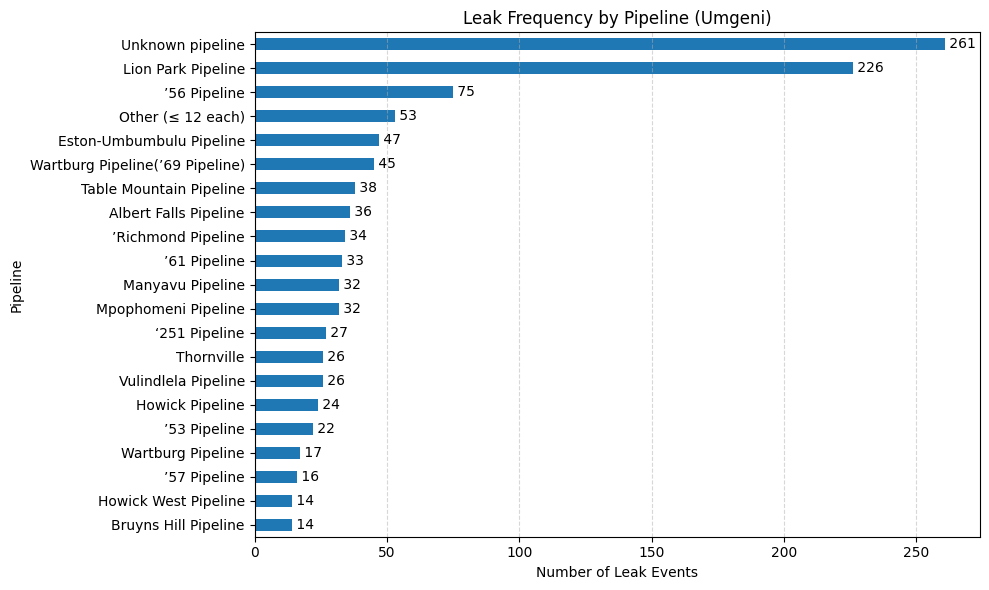

In [17]:
def plot_leak_by_pipeline(df: pd.DataFrame, top_n: int = 20) -> None:
    # 1) pick the working frame and leak mask
    if "target_leak" not in df.columns:
        print("No 'target_leak' column found.")
        return
    m = df["target_leak"] == 1
    if not m.any():
        print("No leak rows to plot.")
        return

    # 2) choose a friendly pipeline label: PIPELINE NAME → pipe_key_match → 'Unknown pipeline'
    name = None
    if "PIPELINE NAME" in df.columns:
        name = df.loc[m, "PIPELINE NAME"]
    elif "pipe_key_match" in df.columns:
        name = df.loc[m, "pipe_key_match"]
    else:
        print("Neither 'PIPELINE NAME' nor 'pipe_key_match' present.")
        return

    labels = name.fillna(df.loc[m, "pipe_key_match"] if "pipe_key_match" in df.columns else "Unknown pipeline")
    labels = labels.fillna("Unknown pipeline").astype(str)

    # 3) counts + “Other” bucket
    vc = labels.value_counts()
    if vc.empty:
        print("No pipeline labels to plot.")
        return

    if len(vc) > top_n:
        top = vc.iloc[:top_n]
        other = vc.iloc[top_n:].sum()
        top.loc[f"Other (≤ {vc.iloc[top_n:].max()} each)"] = other
        vc = top

    # 4) barh plot, sorted ascending so largest sits on top
    vc = vc.sort_values(ascending=True)

    ax = vc.plot(kind="barh", figsize=(10, 6))
    ax.set_title("Leak Frequency by Pipeline (Umgeni)")
    ax.set_xlabel("Number of Leak Events")
    ax.set_ylabel("Pipeline")

    # annotate counts at bar end
    for i, v in enumerate(vc.values):
        ax.text(v, i, f" {int(v)}", va="center")

    ax.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Use it with your merged table (rep after merge), or pass merged_token if that's your df
plot_leak_by_pipeline(rep if "rep" in globals() else merged_token, top_n=20)


## Build leak summaries by pipeline (counts, shares, optional rate per km)
Creates a tidy table with:
- `leak_count`: number of leak work orders
- `wo_total`: total work orders for the pipeline (leak + non-leak)
- `leak_share`: leak_count / wo_total
- `leaks_per_km`: optional if `TOTAL LENGTH (KM)` is available in the merged frame

Also emits a **monthly** leak breakdown if `event_date` exists.


In [18]:
# Choose pipeline label: prefer PIPELINE NAME -> pipe_key_match -> 'Unknown pipeline'
def _pick_label_col(df):
    if "PIPELINE NAME" in df.columns:
        return "PIPELINE NAME"
    if "pipe_key_match" in df.columns:
        return "pipe_key_match"
    return None  # signals we have no label columns

label_col = _pick_label_col(rep)
if label_col is None:
    print("Neither 'PIPELINE NAME' nor 'pipe_key_match' is present. Cannot summarize by pipeline.")
else:
    # Build a clean label Series for all rows (not just leaks)
    pipe_label = rep[label_col].fillna(
        rep["pipe_key_match"] if "pipe_key_match" in rep.columns else "Unknown pipeline"
    ).fillna("Unknown pipeline").astype(str)

    # Working view
    _tmp = rep.copy()
    _tmp["__pipe_label__"] = pipe_label
    _tmp["__is_leak__"] = (_tmp["target_leak"] == 1) if "target_leak" in _tmp.columns else False

    # --- Core aggregates ---
    grp = _tmp.groupby("__pipe_label__", dropna=False)

    # counts
    leak_count = grp["__is_leak__"].sum().rename("leak_count")     # Series(index=pipeline)
    wo_total   = grp["__is_leak__"].size().rename("wo_total")       # Series(index=pipeline)

    # assemble
    leak_summary = (
        pd.concat([leak_count, wo_total], axis=1)
          .reset_index()
          .rename(columns={"__pipe_label__": "pipeline"})
    )
    leak_summary["leak_share"] = (leak_summary["leak_count"] / leak_summary["wo_total"]).round(4)

    # optional: leaks per km if TOTAL LENGTH (KM) exists in the working frame
    if "TOTAL LENGTH (KM)" in _tmp.columns:
        # representative length per pipeline (first non-null), then coerce numeric
        length_km = grp["TOTAL LENGTH (KM)"].first().rename("length_km")
        # FIX: use rename_axis + reset_index(name=...) instead of names=
        length_km_df = length_km.rename_axis("pipeline").reset_index(name="length_km")
        length_km_df["length_km"] = pd.to_numeric(length_km_df["length_km"], errors="coerce")

        leak_summary = leak_summary.merge(length_km_df, on="pipeline", how="left")
        leak_summary["leaks_per_km"] = (
            (leak_summary["leak_count"] / leak_summary["length_km"])
            .replace([np.inf, -np.inf], np.nan)
            .round(4)
        )
    else:
        leak_summary["length_km"] = np.nan
        leak_summary["leaks_per_km"] = np.nan

    # sort by most leaks
    leak_summary = leak_summary.sort_values(["leak_count", "wo_total"], ascending=[False, False]).reset_index(drop=True)

    # --- Top 20 view (for convenience) ---
    top20 = leak_summary.head(20).copy()

    # --- Optional monthly breakdown (only if event_date present) ---
    if "event_date" in _tmp.columns and pd.api.types.is_datetime64_any_dtype(_tmp["event_date"]):
        _tmp["event_month"] = _tmp["event_date"].dt.to_period("M").dt.to_timestamp()
        monthly = (
            _tmp[_tmp["__is_leak__"]]
            .groupby(["__pipe_label__", "event_month"])
            .size()
            .rename("leak_count")
            .reset_index()
            .rename(columns={"__pipe_label__": "pipeline"})
            .sort_values(["pipeline","event_month"])
            .reset_index(drop=True)
        )
    else:
        monthly = pd.DataFrame(columns=["pipeline","event_month","leak_count"])

    # small preview
    print("Leak summary head():")
    display(leak_summary.head(10))
    if not monthly.empty:
        print("\nMonthly leak breakdown head():")
        display(monthly.head(10))


Leak summary head():


,pipeline,leak_count,wo_total,leak_share,length_km,leaks_per_km
0,Unknown pipeline,261,2160,0.1208,NaN,NaN
1,Lion Park Pipeline,226,522,0.4330,8.6000,26.2791
2,’56 Pipeline,75,489,0.1534,7.3000,10.2740
3,Eston-Umbumbulu Pipeline,47,302,0.1556,16.1000,2.9193
4,Wartburg Pipeline(’69 Pipeline),45,143,0.3147,19.3000,2.3316
5,Table Mountain Pipeline,38,102,0.3725,14.8000,2.5676
6,Albert Falls Pipeline,36,96,0.3750,10.3000,3.4951
7,’Richmond Pipeline,34,210,0.1619,4.9000,6.9388
8,’61 Pipeline,33,268,0.1231,6.2000,5.3226
9,Manyavu Pipeline,32,104,0.3077,13.0000,2.4615



Monthly leak breakdown head():


,pipeline,event_month,leak_count
0,261 Pipeline,2020-02-01,1
1,261 Pipeline,2020-03-01,1
2,261 Pipeline,2020-10-01,1
3,261 Pipeline,2021-01-01,1
4,261 Pipeline,2021-06-01,1
5,261 Pipeline,2021-12-01,1
6,60 Pipeline,2020-04-01,1
7,60 Pipeline,2020-10-01,1
8,60 Pipeline,2022-01-01,1
9,60 Pipeline,2025-02-01,1


## Export CSVs
- Full leak summary (`leak_summary_by_pipeline.csv`)
- Top 20 pipelines (`leak_summary_top20.csv`)
- Monthly leak breakdown (`leak_monthly_by_pipeline.csv`, if available)


In [19]:
if label_col is None:
    print("Skip exports: no pipeline label available.")
else:
    leak_summary.to_csv("outputs/leak_summary_by_pipeline.csv", index=False)
    print("Saved: leak_summary_by_pipeline.csv")

    top20.to_csv("outputs/leak_summary_top20.csv", index=False)
    print("Saved: leak_summary_top20.csv")

    # Export monthly only if non-empty
    if 'monthly' in locals() and not monthly.empty:
        monthly.to_csv("outputs/leak_monthly_by_pipeline.csv", index=False)
        print("Saved: leak_monthly_by_pipeline.csv")
    else:
        print("Monthly breakdown not available (missing or empty).")


Saved: leak_summary_by_pipeline.csv
Saved: leak_summary_top20.csv
Saved: leak_monthly_by_pipeline.csv


In [20]:
# Build a model-ready dataset from row-level `rep`
# - one row per work order
# - select useful columns
# - add simple date features
# - keep only rows with a target label

if "event_date" not in rep.columns:
    raise ValueError("event_date missing. Make sure you ran the event_date parsing step.")

model_cols_text = [c for c in ["Problem_Description","Description","Location_Description"] if c in rep.columns]
model_cols_cat  = [c for c in ["Order Type","Priority","MaintActivType","System status","SYSTEM","SUB SYSTEM","Material"] if c in rep.columns]
model_cols_num  = [c for c in ["Nominal Diameter","TOTAL LENGTH (KM)","PIPELINE AGE","CAPACITY MLD","Total act.costs","TotalPlnndCosts"] if c in rep.columns]
id_cols         = [c for c in ["Order","asset_key","pipe_key_match","PIPELINE NAME"] if c in rep.columns]

df = rep.copy()

# Date features
df["event_year"]   = df["event_date"].dt.year
df["event_month"]  = df["event_date"].dt.month
df["event_dow"]    = df["event_date"].dt.dayofweek  # 0=Mon
df["is_weekend"]   = df["event_dow"].isin([5,6]).astype("int8")

# Keep only rows with known target
if "target_leak" not in df.columns:
    raise ValueError("target_leak missing. Run the leak flag step first.")

keep_cols = id_cols + model_cols_text + model_cols_cat + model_cols_num + ["event_year","event_month","event_dow","is_weekend","target_leak"]
keep_cols = [c for c in keep_cols if c in df.columns]
model_df  = df[keep_cols].dropna(subset=["target_leak"]).reset_index(drop=True)

# (Optional) very light cleaning of numeric columns
for c in set(model_cols_num) & set(model_df.columns):
    model_df[c] = pd.to_numeric(model_df[c], errors="coerce")

# Save for modeling
model_df.to_csv("outputs/work_orders_model_ready.csv", index=False)
print(f"Saved model-ready table with {len(model_df):,} rows and {len(model_df.columns)} columns -> work_orders_model_ready.csv")


Saved model-ready table with 6,260 rows and 25 columns -> work_orders_model_ready.csv


In [24]:
model_df.columns.tolist()

['Order',
 'asset_key',
 'pipe_key_match',
 'PIPELINE NAME',
 'Problem_Description',
 'Description',
 'Location_Description',
 'Order Type',
 'Priority',
 'MaintActivType',
 'System status',
 'SYSTEM',
 'SUB SYSTEM',
 'Material',
 'Nominal Diameter',
 'TOTAL LENGTH (KM)',
 'PIPELINE AGE',
 'CAPACITY MLD',
 'Total act.costs',
 'TotalPlnndCosts',
 'event_year',
 'event_month',
 'event_dow',
 'is_weekend',
 'target_leak']

C:\Users\samke\AppData\Local\Temp\ipykernel_39256\3112300369.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabels.get(x, str(x)) for x in order])


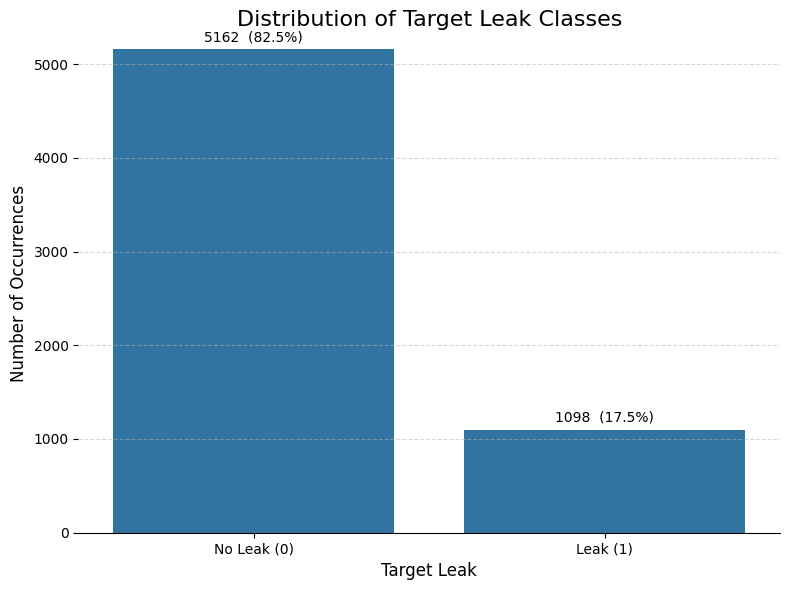

In [22]:
import seaborn as sns

# Compute counts/pct from your dataframe (rep); fall back if you already have vc/pct
try:
    vc = rep["target_leak"].value_counts().sort_index()
except Exception:
    # If rep isn't available, assume vc was computed earlier
    pass

total = vc.sum()
pct = (vc / total * 100).round(1)

# Build a plotting table to keep things aligned
plot_df = (
    vc.rename("count")
      .to_frame()
      .assign(pct=pct)
      .reset_index()
      .rename(columns={"index": "target_leak"})
)

# Make human labels in desired order if 0/1 both present
order = [0, 1] if set(plot_df["target_leak"]) >= {0, 1} else plot_df["target_leak"].tolist()
xlabels = {0: "No Leak (0)", 1: "Leak (1)"}
plot_df["label"] = plot_df["target_leak"].map(xlabels).fillna(plot_df["target_leak"].astype(str))

# Plot (Option A: single color – avoids the seaborn palette warning cleanly)
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=plot_df,
    x="label", y="count",
    order=[xlabels.get(x, str(x)) for x in order],
    ax=ax, color="tab:blue"
)

# (Option B to keep a palette: uncomment, and comment out the block above)
# sns.barplot(
#     data=plot_df,
#     x="label", y="count",
#     hue="label", palette="viridis", legend=False,
#     order=[xlabels.get(x, str(x)) for x in order],
#     ax=ax
# )

# Annotate each bar with "count (pct%)"
# Use a small relative offset so it scales with your data
ymax = plot_df["count"].max()
offset = max(0.01 * ymax, 1)

for bar, (_, row) in zip(ax.patches, plot_df.iterrows()):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{int(row['count'])}  ({row['pct']}%)",
        ha="center", va="bottom", fontsize=10
    )

# Cosmetics
ax.set_title("Distribution of Target Leak Classes", fontsize=16)
ax.set_xlabel("Target Leak", fontsize=12)
ax.set_ylabel("Number of Occurrences", fontsize=12)  # fixed spelling
ax.set_xticklabels([xlabels.get(x, str(x)) for x in order])
ax.set_ylim(0, ymax + 3 * offset)  # add headroom for labels
ax.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine(left=True)
plt.tight_layout()
plt.show()


## Select core columns & tidy numerics/materials
- Verify expected columns exist.
- Clean **Age** and **Diameter**:
  - coerce to numeric,
  - optionally enforce positive values,
  - winsorize to quantiles (clip, not drop),
  - **preserve original index** and NA positions.
- Normalize **Material** names (handle common variants like uPVC/PVC-U, AC, FC, DI, HDPE, Steel) and fill unknowns.


In [ ]:
# Point `dataset` at the working frame and create final__ columns
dataset = rep.copy()

def _first_present(df: pd.DataFrame, candidates: list[str]) -> pd.Series:
    """Return the first existing column from `candidates`; else an all-NA Series aligned to df."""
    for c in candidates:
        if c in df.columns:
            return df[c]
    return pd.Series(pd.NA, index=df.index)

dataset["final__PIPELINE AGE"] = _first_present(dataset, ["PIPELINE AGE", "heur_PIPELINE AGE"])
dataset["final__Nominal Diameter"] = _first_present(dataset, ["Nominal Diameter", "heur_Nominal Diameter"])
dataset["final__Material"] = _first_present(dataset, ["Material", "heur_Material"])

# Tidy numerics (age, diameter) and materials
AGE_COL  = "final__PIPELINE AGE"
DIAM_COL = "final__Nominal Diameter"
MAT_COL  = "final__Material"

# sanity: at least one of the expected columns should exist
expected = [AGE_COL, DIAM_COL, MAT_COL]
present  = [c for c in expected if c in dataset.columns]
if not present:
    raise ValueError(f"No expected columns found. Have: {dataset.columns.tolist()}")

def clean_numeric(s: pd.Series, *, clip_q=(0.01, 0.99), positive_only: bool = False) -> pd.Series:
    """
    Coerce to numeric, optionally drop non-positive (set to NA), and winsorize to quantiles.
    Returns a Series aligned to the input index.
    """
    out = pd.to_numeric(s, errors="coerce")
    if positive_only:
        out = out.mask(out <= 0)
    nn = out.dropna()
    if len(nn) >= 5 and clip_q is not None:
        lo, hi = nn.quantile(clip_q[0]), nn.quantile(clip_q[1])
        if pd.notna(lo) and pd.notna(hi) and hi >= lo:
            out = out.clip(lower=lo, upper=hi)
    return out

def tidy_material(series: pd.Series) -> pd.Series:
    """
    Normalize material labels to a compact set: uPVC, AC, FC, DI, HDPE, Steel, Concrete, or fallback.
    """
    s = series.astype("string").str.strip()
    s = s.replace({"": pd.NA, "None": pd.NA, "none": pd.NA, "NaN": pd.NA, "nan": pd.NA})
    low = s.str.lower()
    out = pd.Series(pd.NA, index=s.index, dtype="string")

    # uPVC family
    mask = low.str.contains(r"\bu\s*-?\s*pvc\b|^mpvc$|^pvc-u$|^upvc$", na=False)
    out.loc[mask & out.isna()] = "uPVC"

    # AC (asbestos cement)
    mask = low.str.contains(r"\bac\b|asbestos", na=False)
    out.loc[mask & out.isna()] = "AC"

    # FC (fibre cement)
    mask = low.str.contains(r"\bfc\b|fibre\s*cemen", na=False)
    out.loc[mask & out.isna()] = "FC"

    # DI (ductile iron)
    mask = low.str.contains(r"\bdi\b|ductile\s*iron", na=False)
    out.loc[mask & out.isna()] = "DI"

    # HDPE / PE
    mask = low.str.contains(r"\bhdpe\b|\bpe100\b|\bpe\b", na=False)
    out.loc[mask & out.isna()] = "HDPE"

    # Steel
    mask = low.str.contains(r"steel", na=False)
    out.loc[mask & out.isna()] = "Steel"

    # Concrete (RC/RCC)
    mask = low.str.contains(r"concrete|\brc\b|\brcc\b", na=False)
    out.loc[mask & out.isna()] = "Concrete"

    # Fallbacks: keep original (title-cased) if present, else "Unknown"
    out = out.fillna(s.str.title()).fillna("Unknown")
    return out

# Clean/engineer features (aligned to dataset.index)
dataset["feat_age"] = clean_numeric(dataset[AGE_COL])   if AGE_COL  in dataset.columns else pd.Series(index=dataset.index, dtype="float64")
dataset["feat_diameter"] = clean_numeric(dataset[DIAM_COL])  if DIAM_COL in dataset.columns else pd.Series(index=dataset.index, dtype="float64")
dataset["feat_material"] = tidy_material(dataset[MAT_COL])   if MAT_COL  in dataset.columns else pd.Series("Unknown", index=dataset.index, dtype="string")

# Quick QA
print(
    "Age non-null:", int(dataset["feat_age"].notna().sum()),
    "| min/max:", (dataset["feat_age"].min(skipna=True), dataset["feat_age"].max(skipna=True))
)
print(
    "Diameter non-null:", int(dataset["feat_diameter"].notna().sum()),
    "| min/max:", (dataset["feat_diameter"].min(skipna=True), dataset["feat_diameter"].max(skipna=True))
)
print("Material top 8:", dataset["feat_material"].value_counts(dropna=False).head(8).to_dict())


Age non-null: 4100 | min/max: (7.0, 66.0)
Diameter non-null: 4100 | min/max: (125.0, 800900800.0)
Material top 8: {'Steel': 2755, 'Unknown': 2160, 'uPVC': 752, 'AC': 302, 'Concrete': 187, 'Klambon': 104}


In [35]:
dataset.head()

,Order,Order Type,Priority,Problem_Description,MaintActivType,System status,Sched. start,Sched. finish,Functional Loc.,Equipment,Description,Location_Description,Total act.costs,TotalPlnndCosts,target_leak,event_date,event_year,event_month,asset_key_raw,asset_key,pipe_key_match,pipe_key_x,SYSTEM_x,SUB SYSTEM_x,PIPELINE NAME_x,...,Material_y,TOTAL LENGTH (KM)_y,Nominal Diameter_y,CAPACITY MLD_y,PIPELINE AGE_y,FROM_y,TO_y,match_reason,pipe_key,SYSTEM,SUB SYSTEM,PIPELINE NAME,Material,TOTAL LENGTH (KM),Nominal Diameter,CAPACITY MLD,PIPELINE AGE,FROM,TO,final__PIPELINE AGE,final__Nominal Diameter,final__Material,feat_age,feat_diameter,feat_material
0,90013224,PM02,5.0000,Shutdown 53P/L,CMN,REL PCNF PRT GMPS MACM PRC SETC,2025-02-04,2025-03-06,UW-II-E-DVHA-BDS-053-53A-PIPEL,10017744,54 Pipeline from DVH to Umlaas Road,53 Pipeline (Complete),"1,267,165.0500","57,534.4500",0,2025-02-04,2025,2,UW-II-E-DVHA-BDS-053-53A-PIPEL,uw ii e dvha bds 053 53a pipel,53 pipeline,None,None,None,None,...,Pre-Stressed Concrete,26.6000,762.0000,45.0000,63.0000,D.V. Harris WTP,Umlaas Road,num,53 pipeline,Upper Mgeni,DV HARRIS,’53 Pipeline,Pre-Stressed Concrete,26.6000,762.0000,45.0000,63.0000,D.V. Harris WTP,Umlaas Road,63.0000,762.0000,Pre-Stressed Concrete,63.0000,762.0000,Concrete
1,763375,PM02,4.0000,Install Pipe Shelter at the Workshop,CMN,REL PCNF GMPS MANC PPRT PRC SETC,2022-01-20,2023-07-31,UW-II-E-MKON-SUP-OPS-AM0-BUILD,10021332,Mkondeni Regional Offices Buildings,Mkondeni Reg.Office Lights & Gen Elec,"1,068,133.7900","421,761.7300",0,2022-01-20,2022,1,UW-II-E-MKON-SUP-OPS-AM0-BUILD,uw ii e mkon sup ops am0 build,None,None,None,None,None,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,Unknown
2,787728,PM02,4.0000,Pls replace gabion stones @ Outfall,CMN,TECO PCNF GMPS NMAT PPRT PRC SETC,2023-08-22,2023-09-30,UW-II-W-MUTS-RWT-MUP-BGO-BUILD,10000150,Balgowan Structural & buildings,Balgowan Sleeve Valve Chamber,"752,186.9000","715,400.0000",0,2023-08-22,2023,8,UW-II-W-MUTS-RWT-MUP-BGO-BUILD,uw ii w muts rwt mup bgo build,albert falls pipeline,None,None,None,None,...,None,NaN,NaN,NaN,NaN,None,None,prefix:fall,albert falls pipeline,Upper Mgeni,DV HARRIS,Albert Falls Pipeline,uPVC,10.3000,200.0000,5.4400,22.0000,Wartburg Pipeline,Thokozani Reservoir,22.0000,200.0000,uPVC,22.0000,200.0000,uPVC
3,777779,PM02,4.0000,attend to pivot tracks need G5 to repair,CMN,TECO GMPS NMAT PPRT PRC SETC,2023-01-11,2023-01-24,UW-II-E-DARV-WWW-DAR-ADM-BUILD,10018955,Buildings & Structures,Grounds and Lands General Equipment,"750,000.0000","750,000.0000",0,2023-01-11,2023,1,UW-II-E-DARV-WWW-DAR-ADM-BUILD,uw ii e darv www dar adm build,None,None,None,None,None,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,Unknown
4,778880,PM02,2.0000,attend pipe leak at 53p/l,BDN,TECO PCNF GMPS PPRT PRC SETC,2023-02-02,2023-02-14,UW-II-E-DVHA-BDS-053-53A-CH051,10003985,53 Pipeline Chamber 51,"Pipe Segment, Between Chamber 51 AND 52","743,095.8700","165,493.3900",1,2023-02-02,2023,2,UW-II-E-DVHA-BDS-053-53A-CH051,uw ii e dvha bds 053 53a ch051,53 pipeline,None,None,None,None,...,Pre-Stressed Concrete,26.6000,762.0000,45.0000,63.0000,D.V. Harris WTP,Umlaas Road,num,53 pipeline,Upper Mgeni,DV HARRIS,’53 Pipeline,Pre-Stressed Concrete,26.6000,762.0000,45.0000,63.0000,D.V. Harris WTP,Umlaas Road,63.0000,762.0000,Pre-Stressed Concrete,63.0000,762.0000,Concrete


#### **Histograms: pipe age & nominal diameter**

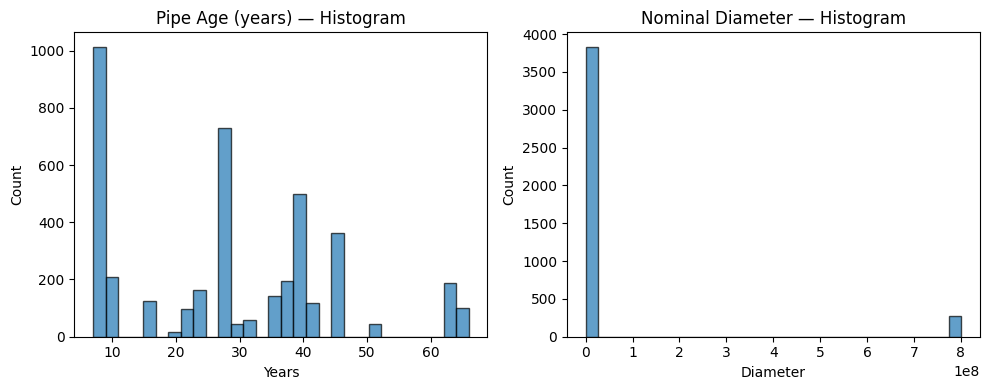

In [27]:
# Define age & dia Series
age = clean_numeric(dataset["final__PIPELINE AGE"]) if "final__PIPELINE AGE" in dataset.columns else pd.Series(dtype=float)
dia = clean_numeric(dataset["final__Nominal Diameter"]) if "final__Nominal Diameter" in dataset.columns else pd.Series(dtype=float)

nplots = int(age.size > 0) + int(dia.size > 0)  # number of plots we WILL draw
fig, axes = plt.subplots(1, nplots, figsize=(10, 4), squeeze=False)
axes = axes.ravel()

i = 0
if age.size:
    axes[i].hist(age, bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title("Pipe Age (years) — Histogram")
    axes[i].set_xlabel("Years"); axes[i].set_ylabel("Count")
    i += 1

if dia.size:
    axes[i].hist(dia, bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title("Nominal Diameter — Histogram")
    axes[i].set_xlabel("Diameter"); axes[i].set_ylabel("Count")

plt.tight_layout(); plt.show()


## Boxplots: Pipe Age & Diameter
This cell:
- Uses **clean, non-null** values from `age` and `dia`.
- Draws boxplots with **5th–95th percentile whiskers** (reduces outlier dominance).
- Keeps outliers visible and **annotates medians**.
- If distributions are highly right-skewed, it automatically switches to a **log scale** for readability.

**Why boxplots?** They’re great for spotting skew, spread, and outliers at a glance—useful to choose transforms (e.g., log) or to set robust binning for models.


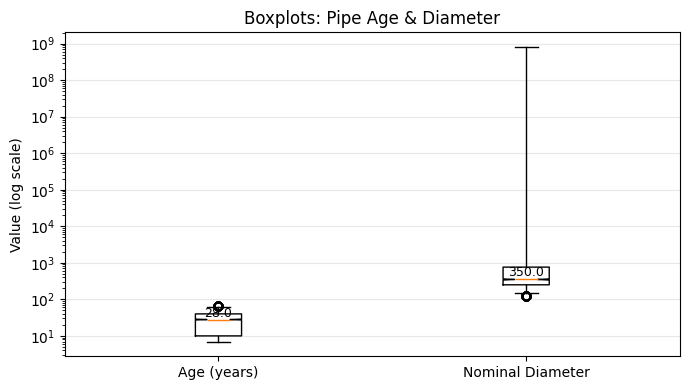

In [28]:
# Build clean, non-null arrays
age_vals = age.dropna().values if isinstance(age, pd.Series) else np.array([])
dia_vals = dia.dropna().values if isinstance(dia, pd.Series) else np.array([])

data, labels = [], []
if age_vals.size: data.append(age_vals); labels.append("Age (years)")
if dia_vals.size: data.append(dia_vals); labels.append("Nominal Diameter")

if not data:
    print("No non-null values in age/diameter to plot.")
else:
    # Simple skew check: if max/min is huge, consider log scaling
    def _is_skewed(arr, thresh=50):
        arr = arr[arr > 0]  # log needs positive values
        return arr.size > 0 and (arr.max() / max(arr.min(), 1e-9)) >= thresh

    use_log = any(_is_skewed(arr) for arr in data)

    plt.figure(figsize=(7, 4))
    bp = plt.boxplot(
        data,
        vert=True,
        showfliers=True,      # keep outliers visible
        whis=(5, 95),         # whiskers at 5th/95th pct to reduce dominance of extremes
        notch=True            # quick visual of median CI
    )

    # X labels
    plt.xticks(range(1, len(labels) + 1), labels, rotation=0)
    plt.title("Boxplots: Pipe Age & Diameter")
    plt.ylabel("Value" + (" (log scale)" if use_log else ""))

    # Optional log scale if very skewed and values are positive
    if use_log:
        plt.yscale("log")

    # Light grid
    plt.grid(axis="y", alpha=0.3)

    # Annotate medians
    medians = [np.median(arr) for arr in data]
    for i, m in enumerate(medians, start=1):
        plt.text(i, m, f"{m:.1f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


#### **Material distribution (bar chart, top N)**

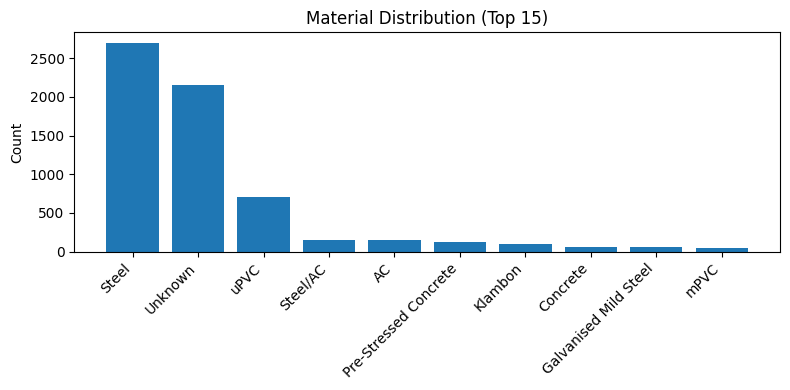

In [ ]:
if mat.size:
    topN = 15  # adjust if you want more/less categories
    vc = mat.value_counts().head(topN)
    plt.figure(figsize=(8,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Material Distribution (Top {topN})")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Material distribution (top N, with “Other” bucket)
This cell:
- Uses `dataset["feat_material"]` if available (else falls back to a material column).
- Aggregates the top N materials and groups the rest into **Other** (labelled with the max count in the tail).
- Plots a tidy horizontal bar chart with **count and share** labels, greying out **Unknown** for clarity.


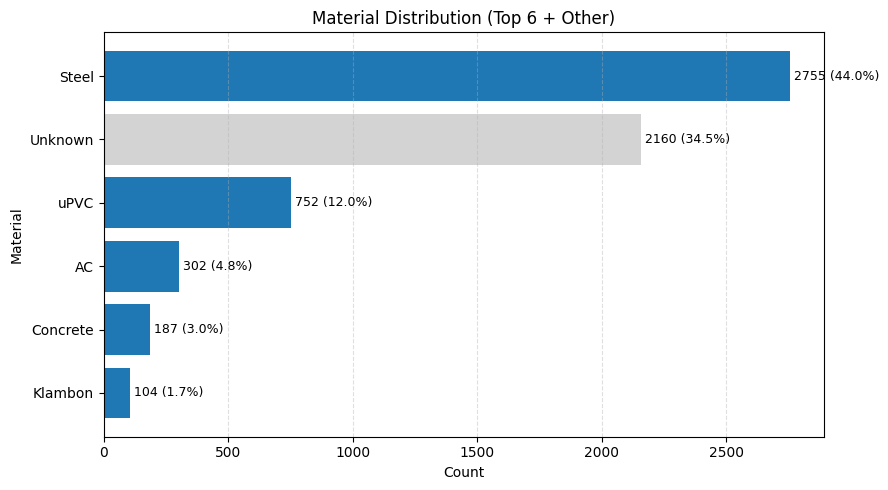

In [29]:
# Choose a source for materials (prefer the cleaned feature)
def _get_material_series(df: pd.DataFrame) -> pd.Series:
    # Use the engineered column if present
    if "feat_material" in df.columns:
        return df["feat_material"]
    # Or use your finalized material column
    if "final__Material" in df.columns:
        return df["final__Material"].astype("string").str.strip()
    # Or raw 'Material' if that's all we have
    if "Material" in df.columns:
        return df["Material"].astype("string").str.strip()
    # Nothing available -> empty series
    return pd.Series(dtype="string", index=df.index)

# Pull materials from the main working frame (not the pipeline metadata `mat`)
materials = _get_material_series(dataset).dropna().astype(str)

if materials.empty:
    print("No material data available to plot.")
else:
    topN = 15  # adjust if you want more/less categories

    # Counts
    vc_all = materials.value_counts()

    # Build “Other” bucket for readability
    if len(vc_all) > topN:
        head = vc_all.iloc[:topN].copy()
        tail = vc_all.iloc[topN:]
        other_sum = int(tail.sum())
        tail_max  = int(tail.max())
        head.loc[f"Other (≤ {tail_max} each)"] = other_sum
        vc = head
    else:
        vc = vc_all

    # Sort for barh (smallest at bottom to largest on top)
    vc = vc.sort_values(ascending=True)

    # Percentages
    pct = (vc / vc.sum() * 100).round(1)

    # Colors: grey out Unknown to de-emphasize
    colors = ["lightgray" if k.strip().lower() in {"unknown", ""} else "tab:blue" for k in vc.index]

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(vc.index.astype(str), vc.values, color=colors)

    # Labels with count and percentage
    for y, (cnt, p) in enumerate(zip(vc.values, pct.values)):
        ax.text(cnt, y, f" {int(cnt)} ({p}%)", va="center", fontsize=9)

    ax.set_title(f"Material Distribution (Top {min(topN, len(vc_all))} + Other)")
    ax.set_xlabel("Count")
    ax.set_ylabel("Material")
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


## Monthly leak incidence
Monthly count of leak work orders. Reconstructs `event_date` from year/month if needed.


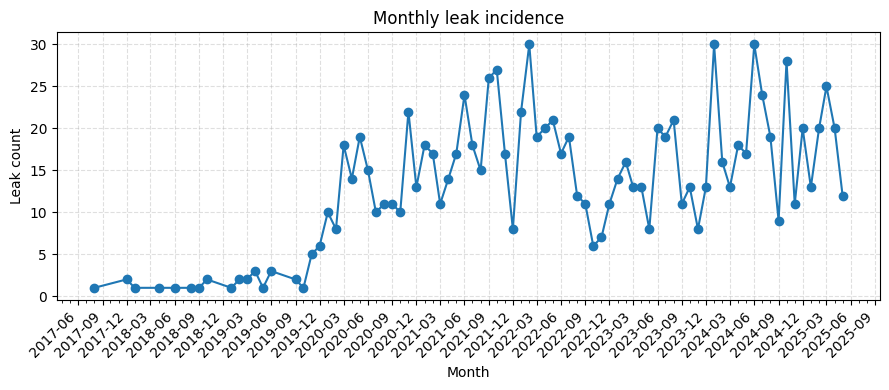

In [34]:
import matplotlib.dates as mdates  # same lib; safe to add

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(monthly.index, monthly.values, marker="o")

# --- force monthly (or every 3 months) ticks and a YYYY-MM label ---
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))   # every 3 months; use 1 for every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())             # minor tick each month

ax.set_title("Monthly leak incidence")
ax.set_xlabel("Month"); ax.set_ylabel("Leak count")
ax.grid(True, linestyle="--", alpha=0.4)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()
